### Toy problem simulating non-stationary timeseries with "regime-shift"

Compare prediction performance of base Echo State Networks (ESNs) with CNN/LSTM hybrid network.

**Outline**

Create timeseries with increasing complexity / difficulty:

1. sin + noise, one amplitude $a_1$, one frequency $f_1$
2. **1st half**: sin + noise, one amplitude $a_1$, one frequency $f_1$, **2nd half**: sin + noise, one amplitude $a_1$, one frequency $f_2$
3. **1st half**: sin + noise, one amplitude $a_1$, one frequency $f_1$, **2nd half**: sin + noise, one amplitude $a_2$, one frequency $f_1$
4. **1st half**: sin + noise, one amplitude $a_1$, one frequency $f_1$, **2nd half**: sin + noise, one amplitude $a_2$, one frequency $f_2$

Look at accuracy (correctly predicted up/down movements) and mean-absolute-error (mae) in total and seperately for both regimes.

**Possible extensions**

* Neglect trend in first step, assume de-trending series is not a big deal.
* Could try to increase noise or different noise-regimes.



### Technical setup and data preparation

In [1]:
import time
import math
import numpy as np
from scipy.special import expit  # vectorized logistig function
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Conv1D, LSTM, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.initializers as tfi
import tensorflow.keras.regularizers as tfr

# Work with my own library of useful ESN functions
from ESN_functions_v01 import *

In [173]:
### Create some data

# Specify number of steps per regime.
n_ = 1000

# Specify input for sin function with linspace(start, stop, numsteps)
t = np.linspace(0, 20*np.pi, n_) 

# Specify noise standard deviation parameter for all input series
n1 = 1

In [95]:
# Create input_1: sin + noise, one amplitude a_1, one frequency f_1

# Set the one amplitude a1, and one base frequency f1
a1 = 1
f1 = 1

# Create raw series (input_raw) and then add noise with np.random.normal(mean, std, numsteps).
input_1_raw = a1 * np.sin(f1 * t)
input_1 = a1 * np.sin(f1 * t) + np.random.normal(0, n1, n_)

In [96]:
# Create input_2: 
# 1st half: sin + noise, one amplitude a_1, one frequency f_1, 
# 2nd half: sin + noise, one amplitude a_1, one frequency f_2

# Set the one amplitude a1, and two base frequencies f1 and f2
a1 = 1
f1 = 1
f2 = 2

# Set up sin with different frequencies for 1st and 2nd half of timeline t, respectively.
# Add noise with same noise parameter over the whole timeline with np.random.normal(mean, std, numsteps).
input_2_raw = np.concatenate((a1 * np.sin(f1 * t[:int(n_ / 2)]), a1 * np.sin(f2 * t[int(n_ / 2):])))
input_2 = np.concatenate((a1 * np.sin(f1 * t[:int(n_ / 2)]), a1 * np.sin(f2 * t[int(n_ / 2):]))) + np.random.normal(0, n1, n_)

In [97]:
# Create input_3: 
# 1st half: sin + noise, one amplitude a_1, one frequency f_1, 
# 2nd half: sin + noise, one amplitude a_2, one frequency f_1

# Set the two amplitudes a1 and a2, and the one frequency f1
a1 = 1
a2 = 0.5
f1 = 1

# Set up sin with different frequencies for 1st and 2nd half of timeline t, respectively.
# Add noise with same noise parameter over the whole timeline with np.random.normal(mean, std, numsteps).
input_3_raw = np.concatenate((a1 * np.sin(f1 * t[:int(n_ / 2)]), a2 * np.sin(f1 * t[int(n_ / 2):])))
input_3 = np.concatenate((a1 * np.sin(f1 * t[:int(n_ / 2)]), a2 * np.sin(f1 * t[int(n_ / 2):]))) + np.random.normal(0, n1, n_)

In [174]:
# Create input_4: 
# 1st half: sin + noise, one amplitude a_1, one frequency f_1, 
# 2nd half: sin + noise, one amplitude a_2, one frequency f_2

# Set the two amplitudes a1 and a2, and the two frequencies f1, f2
a1 = 1
a2 = 0.5
f1 = 1
f2 = 2

# Set up sin with different frequencies for 1st and 2nd half of timeline t, respectively.
# Add noise with same noise parameter over the whole timeline with np.random.normal(mean, std, numsteps).
input_4_raw = np.concatenate((a1 * np.sin(f1 * t[:int(n_ / 2)]), a2 * np.sin(f2 * t[int(n_ / 2):]))) 
input_4 = np.concatenate((a1 * np.sin(f1 * t[:int(n_ / 2)]), a2 * np.sin(f2 * t[int(n_ / 2):]))) + np.random.normal(0, n1, n_)

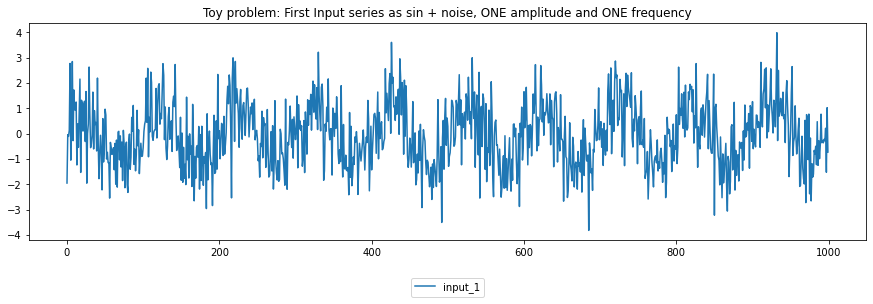

In [99]:
# Plot 1st input series
plt.figure(figsize=(15, 4))
plt.plot(range(len(input_1)), input_1, label='input_1')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.title('Toy problem: First Input series as sin + noise, ONE amplitude and ONE frequency')
plt.show()

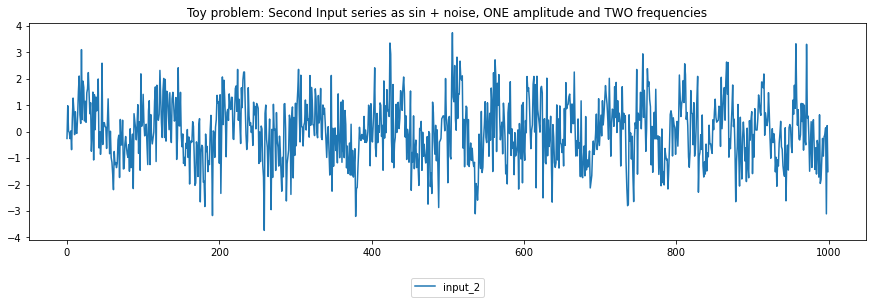

In [100]:
# Plot 2nd input series
plt.figure(figsize=(15, 4))
plt.plot(range(len(input_2)), input_2, label='input_2')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.title('Toy problem: Second Input series as sin + noise, ONE amplitude and TWO frequencies')
plt.show()

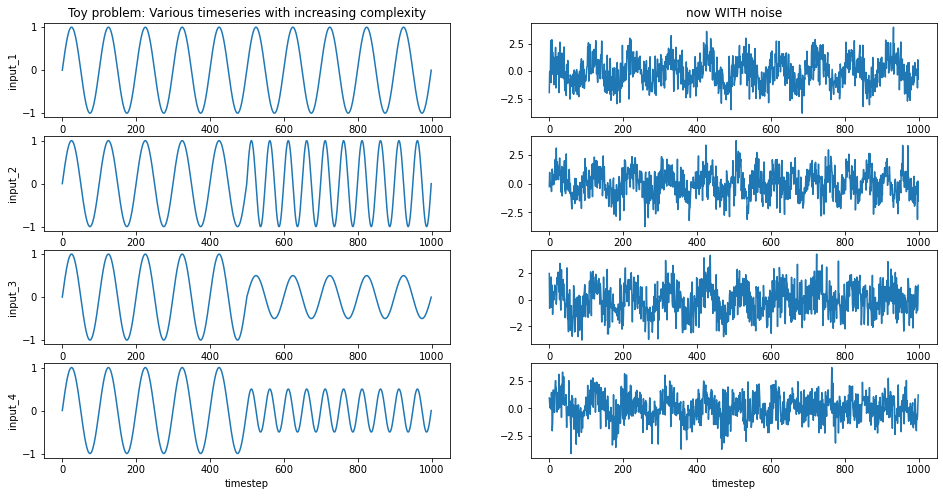

In [175]:
fig, axes = plt.subplots(4, 2, figsize=(16,8))
axes[0,0].plot(range(len(input_1)), input_1_raw, label='input_1')
axes[1,0].plot(range(len(input_2)), input_2_raw, label='input_2')
axes[2,0].plot(range(len(input_3)), input_3_raw, label='input_3')
axes[3,0].plot(range(len(input_4)), input_4_raw, label='input_4')
axes[0,1].plot(range(len(input_1)), input_1, label='input_1')
axes[1,1].plot(range(len(input_2)), input_2, label='input_2')
axes[2,1].plot(range(len(input_3)), input_3, label='input_3')
axes[3,1].plot(range(len(input_4)), input_4, label='input_4')
axes[3,0].set_xlabel("timestep")
axes[3,1].set_xlabel("timestep")
axes[0,0].set_ylabel("input_1")
axes[1,0].set_ylabel("input_2")
axes[2,0].set_ylabel("input_3")
axes[3,0].set_ylabel("input_4")
axes[0,0].set_title("Toy problem: Various timeseries with increasing complexity")
axes[0,1].set_title("now WITH noise")
plt.show()

### Single run for ESN on input_1

In [35]:
### Train base ESN on input_1:

# Get verbose function outputs:
verbose = True

# Set input and target parameters:
input_length = 10
target_length = 1
time_lag = 0
train_val_split = 0.8

# Work with unscaled absolute values:
abs_to_rel_YN = False
binary_YN = False
scaled_YN = False
abs_values_YN = True

# Set reservoir parameters:
n_res=100
sparsity=0.2
spectral_rad=1.2
w_in_lim=1.0
activation='sigmoid'

# Create inputs and targets from absolute data
train_input, val_input, train_target, val_target, train_min, train_max = split_data(input_1, 
                                                                                    input_length = input_length, 
                                                                                    target_length = target_length, 
                                                                                    time_lag=time_lag,
                                                                                    train_val_split=train_val_split, 
                                                                                    abs_to_rel_YN=abs_to_rel_YN,
                                                                                    binary_YN=binary_YN, 
                                                                                    scaled_YN=scaled_YN,
                                                                                    verbose=verbose)

# Train base ESN.
# Note: Third dimension in train_input shape is for time_lag. Have only one slice here.
W_in, W_res, W_out = trainESN(train_input[:,:,0], train_target, 
                              n_res=n_res, 
                              sparsity=sparsity, 
                              spectral_rad=spectral_rad, 
                              w_in_lim=w_in_lim, 
                              activation=activation, 
                              verbose=verbose)

# Get prediction on validation data and evaluation metrics
val_target, val_pred, accuracy, mae = predESN(W_in, W_res, W_out, val_input[:,:,0], val_target, 
                                              activation=activation,
                                              abs_values_YN=abs_values_YN,
                                              scaled_YN=scaled_YN, 
                                              train_min=train_min, 
                                              train_max=train_max, 
                                              verbose=verbose)

raw data shape:  (1000,)
train_input shape:  (792, 10, 1)
val_input shape:  (198, 10, 1)
train_target shape:  (792,)
val_target shape:  (198,)
train_min:  0
train_max:  0
train_input shape:  (792, 10)
train_target shape:  (1, 792)
W_in shape:  (100, 1)
W_out shape:  (1, 100)
W_res shape:  (100, 100)
W_res max:  0.449
W_res sparsity:  0.196
val_input shape:  (198, 10)
val_target shape:  (198,)
val_pred shape:  (198,)
W_in shape:  (100, 1)
W_out shape:  (1, 100)
W_res shape:  (100, 100)
up movements percentage in val_target:  0.32
ESN pred. accuracy:  0.528
ESN mean abs. error:  0.8366


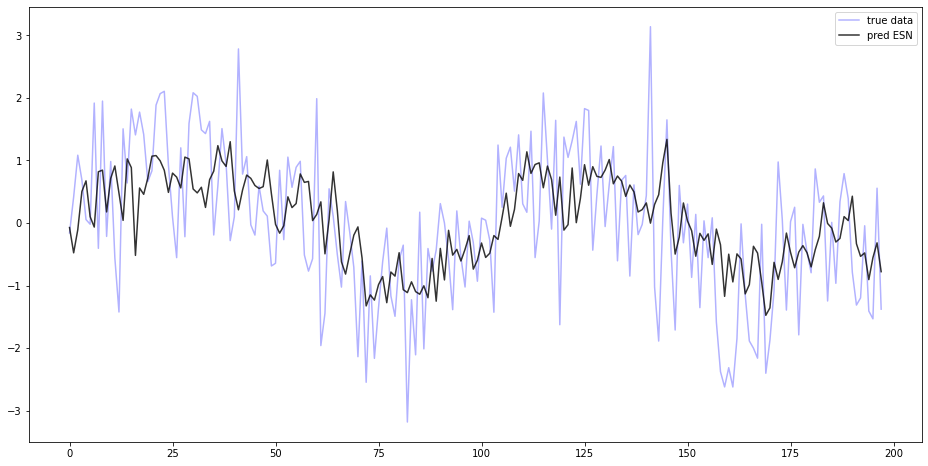

In [36]:
# Fidelity check: Plot true vs. predicted absolute values
plt.figure(figsize=(16,8))
plt.plot(range(len(val_target)),val_target,'b',label="true data", alpha=0.3)
plt.plot(range(len(val_pred)),val_pred,'k',  alpha=0.8, label='pred ESN')
plt.legend()
plt.show()

### Single run for ESN on input_2

In [73]:
### Train base ESN on input_2:

# Get verbose function outputs:
verbose = True

# Set input and target parameters:
input_length = 10
target_length = 1
time_lag = 0
train_val_split = 0.8
val_samples_from = 'start_end'

# Work with unscaled absolute values:
abs_to_rel_YN = False
binary_YN = False
scaled_YN = False
abs_values_YN = True

# Set reservoir parameters:
n_res=100
sparsity=0.2
spectral_rad=1.2
w_in_lim=1.0
activation='sigmoid'

# Create inputs and targets from absolute data
train_input, val_input, train_target, val_target, train_min, train_max = split_data(input_2, 
                                                                                    input_length = input_length, 
                                                                                    target_length = target_length, 
                                                                                    time_lag=time_lag,
                                                                                    train_val_split=train_val_split, 
                                                                                    val_samples_from=val_samples_from,
                                                                                    abs_to_rel_YN=abs_to_rel_YN,
                                                                                    binary_YN=binary_YN, 
                                                                                    scaled_YN=scaled_YN,
                                                                                    verbose=verbose)

# Train base ESN.
# Note: Third dimension in train_input shape is for time_lag. Have only one slice here.
W_in, W_res, W_out = trainESN(train_input[:,:,0], train_target, 
                              n_res=n_res, 
                              sparsity=sparsity, 
                              spectral_rad=spectral_rad, 
                              w_in_lim=w_in_lim, 
                              activation=activation, 
                              verbose=verbose)

# Get prediction on validation data and evaluation metrics
val_target, val_pred, accuracy, mae = predESN(W_in, W_res, W_out, val_input[:,:,0], val_target, 
                                              activation=activation,
                                              abs_values_YN=abs_values_YN,
                                              scaled_YN=scaled_YN, 
                                              train_min=train_min, 
                                              train_max=train_max, 
                                              verbose=verbose)

raw data shape:  (1000,)
train_input shape:  (794, 10, 1)
val_input shape:  (196, 10, 1)
train_target shape:  (794,)
val_target shape:  (196,)
train_min:  0
train_max:  0
train_input shape:  (794, 10)
train_target shape:  (1, 794)
W_in shape:  (100, 1)
W_out shape:  (1, 100)
W_res shape:  (100, 100)
W_res max:  0.483
W_res sparsity:  0.194
val_input shape:  (196, 10)
val_target shape:  (196,)
val_pred shape:  (196,)
W_in shape:  (100, 1)
W_out shape:  (1, 100)
W_res shape:  (100, 100)
up movements percentage in val_target:  0.338
ESN pred. accuracy:  0.451
ESN mean abs. error:  0.9143


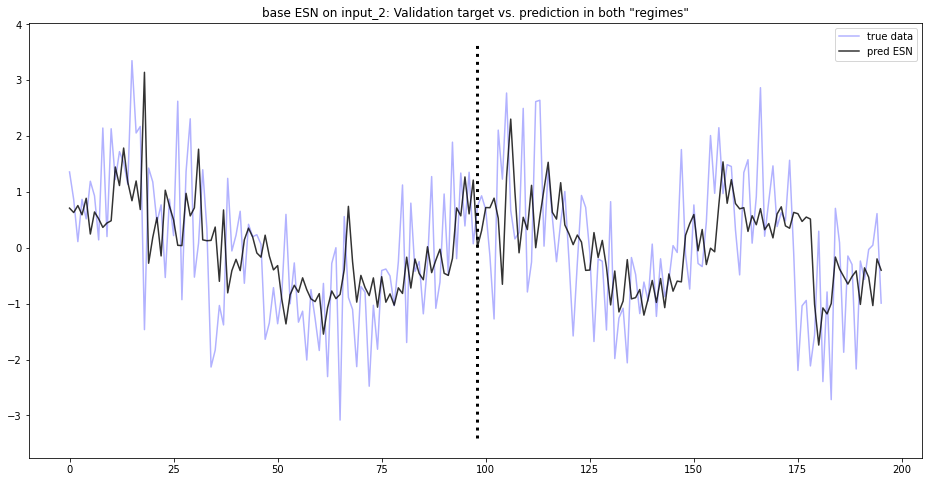

In [78]:
# Fidelity check: Plot true vs. predicted absolute values
plt.figure(figsize=(16,8))
plt.plot(range(len(val_target)),val_target,'b',label="true data", alpha=0.3)
plt.plot(range(len(val_pred)),val_pred,'k',  alpha=0.8, label='pred ESN')

# Add vertical line separating both regimes, since we samples validation data from start and end
lo,hi = plt.ylim()
plt.plot([len(val_pred)/2,len(val_pred)/2],[lo+np.spacing(1),hi-np.spacing(1)],'k:', linewidth=3)

plt.title('base ESN on input_2: Validation target vs. prediction in both "regimes"')
plt.legend()
plt.show()

### Single run for ESN on input_3

In [102]:
### Train base ESN on input_3:

# Get verbose function outputs:
verbose = True

# Set input and target parameters:
input_length = 10
target_length = 1
time_lag = 0
train_val_split = 0.8
val_samples_from = 'start_end'

# Work with unscaled absolute values:
abs_to_rel_YN = False
binary_YN = False
scaled_YN = False
abs_values_YN = True

# Set reservoir parameters:
n_res=100
sparsity=0.2
spectral_rad=1.2
w_in_lim=1.0
activation='sigmoid'

# Create inputs and targets from absolute data
train_input, val_input, train_target, val_target, train_min, train_max = split_data(input_3, 
                                                                                    input_length = input_length, 
                                                                                    target_length = target_length, 
                                                                                    time_lag=time_lag,
                                                                                    train_val_split=train_val_split, 
                                                                                    val_samples_from=val_samples_from,
                                                                                    abs_to_rel_YN=abs_to_rel_YN,
                                                                                    binary_YN=binary_YN, 
                                                                                    scaled_YN=scaled_YN,
                                                                                    verbose=verbose)

# Train base ESN.
# Note: Third dimension in train_input shape is for time_lag. Have only one slice here.
W_in, W_res, W_out = trainESN(train_input[:,:,0], train_target, 
                              n_res=n_res, 
                              sparsity=sparsity, 
                              spectral_rad=spectral_rad, 
                              w_in_lim=w_in_lim, 
                              activation=activation, 
                              verbose=verbose)

# Get prediction on validation data and evaluation metrics
val_target, val_pred, accuracy, mae = predESN(W_in, W_res, W_out, val_input[:,:,0], val_target, 
                                              activation=activation,
                                              abs_values_YN=abs_values_YN,
                                              scaled_YN=scaled_YN, 
                                              train_min=train_min, 
                                              train_max=train_max, 
                                              verbose=verbose)

raw data shape:  (1000,)
train_input shape:  (794, 10, 1)
val_input shape:  (196, 10, 1)
train_target shape:  (794,)
val_target shape:  (196,)
train_min:  0
train_max:  0
train_input shape:  (794, 10)
train_target shape:  (1, 794)
W_in shape:  (100, 1)
W_out shape:  (1, 100)
W_res shape:  (100, 100)
W_res max:  0.441
W_res sparsity:  0.202
val_input shape:  (196, 10)
val_target shape:  (196,)
val_pred shape:  (196,)
W_in shape:  (100, 1)
W_out shape:  (1, 100)
W_res shape:  (100, 100)
up movements percentage in val_target:  0.251
ESN pred. accuracy:  0.503
ESN mean abs. error:  0.8751


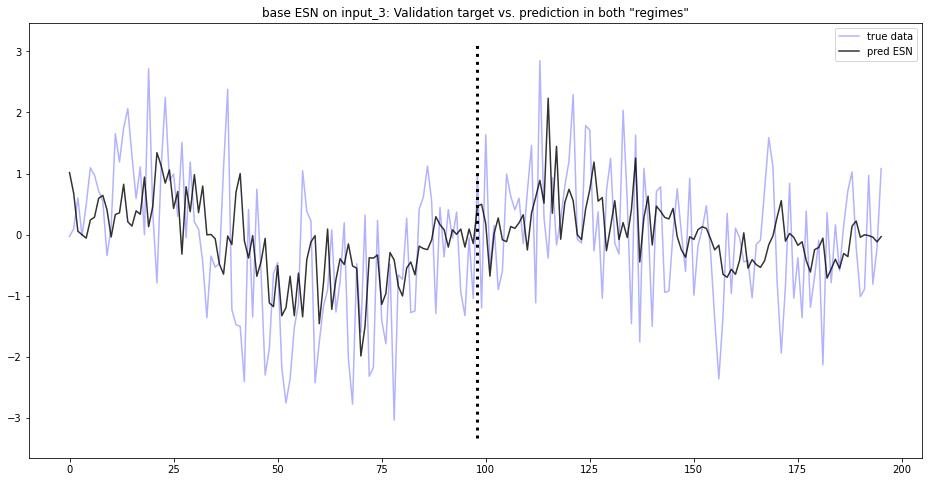

In [103]:
# Fidelity check: Plot true vs. predicted absolute values
plt.figure(figsize=(16,8))
plt.plot(range(len(val_target)),val_target,'b',label="true data", alpha=0.3)
plt.plot(range(len(val_pred)),val_pred,'k',  alpha=0.8, label='pred ESN')

# Add vertical line separating both regimes, since we samples validation data from start and end
lo,hi = plt.ylim()
plt.plot([len(val_pred)/2,len(val_pred)/2],[lo+np.spacing(1),hi-np.spacing(1)],'k:', linewidth=3)

plt.title('base ESN on input_3: Validation target vs. prediction in both "regimes"')
plt.legend()
plt.show()

In [ ]:
### Single run for ESN on input_4

In [176]:
### Train base ESN on input_4:

# Get verbose function outputs:
verbose = True

# Set input and target parameters:
input_length = 10
target_length = 1
time_lag = 0
train_val_split = 0.8
val_samples_from = 'start_end'

# Work with unscaled absolute values:
abs_to_rel_YN = False
binary_YN = False
scaled_YN = False
abs_values_YN = True

# Set reservoir parameters:
n_res=100
sparsity=0.2
spectral_rad=1.2
w_in_lim=1.0
activation='sigmoid'

# Create inputs and targets from absolute data
train_input, val_input, train_target, val_target, train_min, train_max = split_data(input_4, 
                                                                                    input_length = input_length, 
                                                                                    target_length = target_length, 
                                                                                    time_lag=time_lag,
                                                                                    train_val_split=train_val_split, 
                                                                                    val_samples_from=val_samples_from,
                                                                                    abs_to_rel_YN=abs_to_rel_YN,
                                                                                    binary_YN=binary_YN, 
                                                                                    scaled_YN=scaled_YN,
                                                                                    verbose=verbose)

# Train base ESN.
# Note: Third dimension in train_input shape is for time_lag. Have only one slice here.
W_in, W_res, W_out = trainESN(train_input[:,:,0], train_target, 
                              n_res=n_res, 
                              sparsity=sparsity, 
                              spectral_rad=spectral_rad, 
                              w_in_lim=w_in_lim, 
                              activation=activation, 
                              verbose=verbose)

# Get prediction on validation data and evaluation metrics
val_target, val_pred, accuracy, mae = predESN(W_in, W_res, W_out, val_input[:,:,0], val_target, 
                                              activation=activation,
                                              abs_values_YN=abs_values_YN,
                                              scaled_YN=scaled_YN, 
                                              train_min=train_min, 
                                              train_max=train_max, 
                                              verbose=verbose)

raw data shape:  (1000,)
train_input shape:  (794, 10, 1)
val_input shape:  (196, 10, 1)
train_target shape:  (794,)
val_target shape:  (196,)
train_min:  0
train_max:  0
train_input shape:  (794, 10)
train_target shape:  (1, 794)
W_in shape:  (100, 1)
W_out shape:  (1, 100)
W_res shape:  (100, 100)
W_res max:  0.456
W_res sparsity:  0.202
val_input shape:  (196, 10)
val_target shape:  (196,)
val_pred shape:  (196,)
W_in shape:  (100, 1)
W_out shape:  (1, 100)
W_res shape:  (100, 100)
up movements percentage in val_target:  0.318
ESN pred. accuracy:  0.508
ESN mean abs. error:  0.959


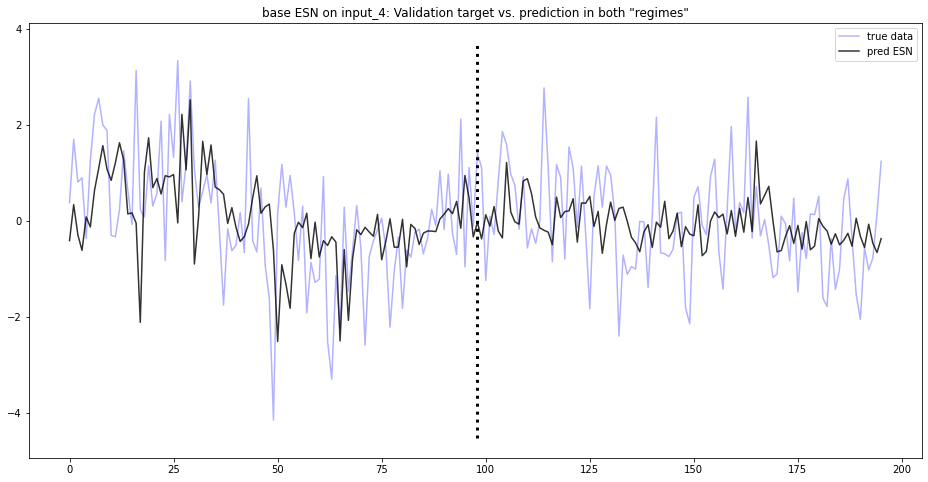

In [177]:
# Fidelity check: Plot true vs. predicted absolute values
plt.figure(figsize=(16,8))
plt.plot(range(len(val_target)),val_target,'b',label="true data", alpha=0.3)
plt.plot(range(len(val_pred)),val_pred,'k',  alpha=0.8, label='pred ESN')

# Add vertical line separating both regimes, since we samples validation data from start and end
lo,hi = plt.ylim()
plt.plot([len(val_pred)/2,len(val_pred)/2],[lo+np.spacing(1),hi-np.spacing(1)],'k:', linewidth=3)

plt.title('base ESN on input_4: Validation target vs. prediction in both "regimes"')
plt.legend()
plt.show()

#### Show single-run ESN and CNN/LSTM prediction on some fixed validation samples from input_4 with parameters:

a1 = 1  
a2 = 0.5  
f1 = 1  
f2 = 2

n1 = 1

In [189]:
# Store target and pred from single run ESN result on input_4: 
val_target_ESN = np.array([ 0.38121286,  1.69715774,  0.80811783,  0.89442223, -0.36912122,
        1.26105417,  2.21793881,  2.55463321,  1.99852026,  1.88214495,
       -0.30182023, -0.3332188 ,  0.23066226,  1.45959912,  0.64143401,
       -0.07446579,  3.13347107,  0.23032603,  0.07778821,  1.14750198,
        0.30936887,  0.56503942,  2.07596458, -0.82642022,  2.2163375 ,
        1.32548939,  3.33792192,  0.39747674,  1.17518726,  2.91231955,
        1.0621957 ,  0.28106851,  0.60942667,  0.96301476,  0.37253636,
        1.26300095, -0.18430323, -1.75658674, -0.16662978, -0.62344268,
       -0.51079137,  0.17034973, -0.66773278,  2.5485336 , -0.41466025,
       -0.64894875,  0.68365388, -0.91441964, -1.62776842, -4.15249173,
        0.14540956,  1.17892821,  0.28503017,  0.94703075,  0.15419891,
       -0.82357288,  0.30615196, -1.91640457, -0.86687447, -1.28245971,
       -1.21618345,  0.9223634 , -2.51329997, -3.30059473, -1.14277313,
       -2.24020353,  0.28355999, -1.46513785, -0.61547265,  0.32017216,
       -0.57166741, -2.58974132, -0.74251655, -0.41884581, -0.1846898 ,
        0.05316727, -0.57013496, -2.21590721, -1.05709361, -0.33455257,
       -1.82537423, -0.61240486, -0.75450643, -0.24171739, -0.17199006,
       -0.68719413, -0.37136203,  0.236484  , -0.09461666,  1.04280149,
       -0.1801961 ,  0.9707756 , -0.25798317, -0.6994395 ,  2.1174192 ,
       -0.96117744,  1.11203165, -0.10770281,  1.40311993,  1.10770817,
       -1.24570536,  0.09551029, -0.28457044,  0.82841348,  1.85731219,
        1.58792779,  0.97578187,  0.73717912, -0.17389334,  0.92056746,
       -0.56453958, -0.16774469, -0.46878526, -0.00562617,  2.7697574 ,
        1.09424567, -0.85369253,  1.17280839,  0.90319041, -0.79595377,
        1.54044528,  1.10292502, -0.14453488,  1.14134915, -0.26010774,
       -1.8313007 ,  0.50836464,  1.14459216,  0.28505763,  1.1434932 ,
        0.95392977,  0.14601395, -2.40086041, -0.71672638, -1.11651243,
       -0.95429617, -1.00574439, -0.00980922, -0.0251237 , -1.38616761,
        0.0855449 ,  2.15822229, -0.66554381, -0.68776271, -0.74458828,
       -0.59380456,  0.1537538 ,  0.18100107, -1.81140724, -2.14636391,
        0.49139011,  0.70995045, -0.09634026, -0.29078151,  0.92573151,
        1.28444152, -0.64292328, -1.4226623 ,  0.23309943,  1.96536357,
       -0.23079106,  0.37870591,  0.17252875,  2.57058857, -0.36009705,
        0.71511344, -0.31325541,  0.02551027, -0.50805379, -1.18433282,
       -1.10863125,  0.09615468, -0.05970713, -0.83494928,  0.47315243,
       -1.48268183, -0.24334409, -0.78202458,  0.14423572,  0.12778576,
        0.51191615, -1.60772677, -1.78618626, -0.37027196, -1.42949265,
       -1.01436022,  0.4490953 ,  0.87343383, -0.37426933, -1.53468287,
       -2.05566038, -0.559769  , -1.02173869, -0.77575339,  0.14563749,
        1.23887885])

val_pred_ESN = np.array([-4.12313321e-01,  3.37373189e-01, -2.91343968e-01, -6.15375540e-01,
        8.10744933e-02, -1.28616481e-01,  6.34311048e-01,  1.09031344e+00,
        1.56732869e+00,  1.07606043e+00,  8.42564676e-01,  1.20334954e+00,
        1.62685993e+00,  1.27129999e+00,  1.43223986e-01,  1.65644810e-01,
       -4.63398165e-02, -2.11622531e+00,  1.01717880e+00,  1.72994406e+00,
        6.91645566e-01,  8.81247865e-01,  5.59496940e-01,  9.40317125e-01,
        9.15461168e-01,  9.64955060e-01, -4.35566538e-02,  2.21988530e+00,
        1.06225332e+00,  2.52084031e+00, -9.00359470e-01,  7.64082429e-02,
        1.65682273e+00,  9.66581854e-01,  1.58045455e+00,  7.03564265e-01,
        6.48928987e-01,  5.54300461e-01, -5.47384762e-02,  2.74286649e-01,
       -1.38447876e-01, -4.29970793e-01, -3.28438018e-01, -6.56436610e-02,
        4.78882834e-01,  9.39015497e-01,  1.57091602e-01,  2.90316599e-01,
        3.49008373e-01, -6.19397670e-01, -2.51511378e+00, -9.15509214e-01,
       -1.32308468e+00, -1.82210543e+00, -2.58231667e-01, -2.93454303e-02,
       -1.42392288e-01,  1.57514475e-01, -7.87592210e-01, -2.77976373e-02,
       -7.52920635e-01, -4.12982151e-01, -5.14763622e-01, -3.31974291e-01,
       -4.44232150e-01, -2.50345208e+00, -5.99196780e-01, -2.07426137e+00,
       -7.91296484e-01, -1.85606902e-01, -2.88226724e-01, -1.34884381e-01,
       -2.33639226e-01, -3.21602041e-01,  1.34711604e-01, -8.11627342e-01,
       -4.24055968e-01,  4.15289002e-02, -5.50035132e-01, -5.48025431e-01,
        3.09476804e-02, -9.60564717e-01, -7.49868921e-02, -1.58733123e-01,
       -4.92063710e-01, -2.58277060e-01, -2.12520632e-01, -2.14570434e-01,
       -2.24046916e-01,  3.83216830e-02,  1.38650790e-01,  2.55025686e-01,
        1.49484948e-01,  4.04873245e-01, -1.54371018e-01,  9.45023851e-01,
        4.68881675e-01, -3.34158984e-01, -3.03539355e-02, -3.76356756e-01,
        1.26531043e-01, -1.11725794e-01,  2.95900826e-01, -2.10634070e-01,
       -3.56517693e-01,  1.21505306e+00,  1.87475368e-01, -2.18472062e-02,
       -6.98778967e-02,  8.29681905e-01,  8.77012537e-01,  5.66796595e-01,
        7.73455802e-02, -1.47548290e-01, -1.97484711e-01, -2.35959561e-01,
       -4.97359093e-01,  4.93807234e-01,  6.70335932e-02,  1.93732875e-01,
        2.07360882e-01,  4.60844110e-01, -4.43277444e-01,  3.72080666e-01,
        3.66473808e-01,  5.09950131e-01, -1.17271111e-01,  1.95984848e-01,
       -6.76373546e-01, -7.80440783e-02,  3.88638674e-01,  1.00648901e-02,
        2.58113256e-01,  2.84680853e-01, -9.39026664e-03, -3.42244414e-01,
       -4.60386120e-01, -6.45051404e-01, -2.30874674e-01, -8.05426675e-02,
       -5.55394554e-01, -2.78083186e-02, -1.33143343e-01,  4.06988814e-01,
       -3.72869694e-01, -2.11443372e-01,  1.58311486e-01, -5.40368695e-01,
       -1.22441972e-01, -2.76210927e-01, -3.11207035e-01,  3.33127271e-01,
       -7.27083407e-01, -6.38016750e-01, -5.98367439e-03,  1.84730660e-01,
        6.81334466e-02,  1.39152590e-01, -2.72810212e-01,  2.14381802e-01,
       -3.22766971e-01,  2.59581330e-01, -2.37136526e-01,  4.85566683e-01,
       -2.20549180e-01,  1.66174795e+00,  3.51715600e-01,  5.29480966e-01,
        7.19483505e-01,  1.03333335e-03, -6.47622240e-01, -6.19414720e-01,
       -3.27760828e-01, -1.01497423e-01, -4.69833236e-01, -9.53286974e-02,
       -5.91045893e-01, -1.53034555e-02, -6.03382237e-01, -5.25738157e-01,
        4.68772442e-02, -1.12521560e-01, -2.09090081e-01, -4.87397260e-01,
       -2.69523591e-01, -5.00353885e-01, -4.06715475e-01, -2.60584727e-01,
       -5.27380232e-01,  5.34283869e-02, -3.20824071e-01, -5.55939918e-01,
       -7.12943612e-02, -4.66406034e-01, -6.59341498e-01, -3.70666346e-01])

val_target_CNNLSTM = np.array([ 2.21793881,  2.55463321,  1.99852026,  1.88214495, -0.30182023,
       -0.3332188 ,  0.23066226,  1.45959912,  0.64143401, -0.07446579,
        3.13347107,  0.23032603,  0.07778821,  1.14750198,  0.30936887,
        0.56503942,  2.07596458, -0.82642022,  2.2163375 ,  1.32548939,
        3.33792192,  0.39747674,  1.17518726,  2.91231955,  1.0621957 ,
        0.28106851,  0.60942667,  0.96301476,  0.37253636,  1.26300095,
       -0.18430323, -1.75658674, -0.16662978, -0.62344268, -0.51079137,
        0.17034973, -0.66773278,  2.5485336 , -0.41466025, -0.64894875,
        0.68365388, -0.91441964, -1.62776842, -4.15249173,  0.14540956,
        1.17892821,  0.28503017,  0.94703075,  0.15419891, -0.82357288,
        0.30615196, -1.91640457, -0.86687447, -1.28245971, -1.21618345,
        0.9223634 , -2.51329997, -3.30059473, -1.14277313, -2.24020353,
        0.28355999, -1.46513785, -0.61547265,  0.32017216, -0.57166741,
       -2.58974132, -0.74251655, -0.41884581, -0.1846898 ,  0.05316727,
       -0.57013496, -2.21590721, -1.05709361, -0.33455257, -1.82537423,
       -0.61240486, -0.75450643, -0.24171739, -0.17199006, -0.68719413,
       -0.37136203,  0.236484  , -0.09461666,  1.04280149, -0.1801961 ,
        0.9707756 , -0.25798317, -0.6994395 ,  2.1174192 , -0.96117744,
        1.11203165, -0.10770281,  1.10690146, -0.22779907,  1.69219246,
       -0.54336694,  1.15658326,  2.6052085 ,  1.40311993,  1.10770817,
       -1.24570536,  0.09551029, -0.28457044,  0.82841348,  1.85731219,
        1.58792779,  0.97578187,  0.73717912, -0.17389334,  0.92056746,
       -0.56453958, -0.16774469, -0.46878526, -0.00562617,  2.7697574 ,
        1.09424567, -0.85369253,  1.17280839,  0.90319041, -0.79595377,
        1.54044528,  1.10292502, -0.14453488,  1.14134915, -0.26010774,
       -1.8313007 ,  0.50836464,  1.14459216,  0.28505763,  1.1434932 ,
        0.95392977,  0.14601395, -2.40086041, -0.71672638, -1.11651243,
       -0.95429617, -1.00574439, -0.00980922, -0.0251237 , -1.38616761,
        0.0855449 ,  2.15822229, -0.66554381, -0.68776271, -0.74458828,
       -0.59380456,  0.1537538 ,  0.18100107, -1.81140724, -2.14636391,
        0.49139011,  0.70995045, -0.09634026, -0.29078151,  0.92573151,
        1.28444152, -0.64292328, -1.4226623 ,  0.23309943,  1.96536357,
       -0.23079106,  0.37870591,  0.17252875,  2.57058857, -0.36009705,
        0.71511344, -0.31325541,  0.02551027, -0.50805379, -1.18433282,
       -1.10863125,  0.09615468, -0.05970713, -0.83494928,  0.47315243,
       -1.48268183, -0.24334409, -0.78202458,  0.14423572,  0.12778576,
        0.51191615, -1.60772677, -1.78618626, -0.37027196, -1.42949265,
       -1.01436022,  0.4490953 ,  0.87343383, -0.37426933, -1.53468287,
       -2.05566038, -0.559769  , -1.02173869, -0.77575339,  0.14563749,
        1.23887885])

val_pred_CNNLSTM = np.array([-4.98607874e-01, -3.00571203e-01, -1.48901701e-01,  1.37435198e-01,
        4.38928366e-01,  6.33416891e-01,  4.19426203e-01,  3.75287771e-01,
        3.70270491e-01,  5.05484819e-01,  2.37491369e-01,  2.82451868e-01,
        4.39986467e-01,  4.94503736e-01,  9.14043188e-01,  9.06055212e-01,
        1.01288009e+00,  9.20403242e-01,  3.52476835e-01,  3.19909334e-01,
        5.09551764e-01,  5.74574232e-01,  9.38372850e-01,  9.43868399e-01,
        1.21503568e+00,  1.37822127e+00,  1.10498595e+00,  9.25045729e-01,
        1.17983603e+00,  1.09523034e+00,  1.12530541e+00,  8.41078520e-01,
        7.22249746e-01,  8.05696249e-01,  3.98763418e-01,  2.18991280e-01,
       -4.57341671e-02, -1.86663628e-01,  1.95646524e-01, -2.02805996e-02,
        6.89027309e-02,  1.38525248e-01,  8.31382275e-02,  1.95431948e-01,
       -2.14992523e-01, -1.53072357e-01, -5.83476543e-01, -4.97117281e-01,
       -7.16624022e-01, -6.26593351e-01, -3.19400311e-01, -3.50393772e-01,
       -3.53908300e-01, -1.61258459e-01, -1.21850491e-01, -2.14944839e-01,
       -4.69675064e-01, -5.44730663e-01, -7.25500584e-01, -5.98088741e-01,
       -1.12470913e+00, -6.85829639e-01, -7.92193413e-01, -2.78401136e-01,
       -1.64053917e-01, -7.65016079e-02, -1.21814013e-01,  5.42550087e-02,
       -3.05917740e-01, -3.28247070e-01, -5.13398647e-01, -8.64084721e-01,
       -1.06194019e+00, -7.99659729e-01, -8.84994268e-01, -8.19386721e-01,
       -9.78435993e-01, -1.04173207e+00, -7.56776571e-01, -7.94908524e-01,
       -1.03330874e+00, -7.23144531e-01, -6.36499643e-01, -6.12008333e-01,
       -5.14675617e-01, -8.48840714e-01, -9.10972595e-01, -7.49178886e-01,
       -7.54227400e-01, -7.47756481e-01, -6.64406300e-01, -3.42506170e-01,
       -1.85360193e-01,  2.17030525e-01,  4.48524952e-02,  1.88562632e-01,
        2.09040403e-01,  2.78128386e-01, -7.58763313e-01, -6.35677576e-01,
       -1.08460903e+00, -1.02172804e+00, -1.24500990e+00, -1.12374425e+00,
       -6.48982763e-01, -3.61316204e-01, -2.72003174e-01, -9.10687447e-02,
       -1.40722752e-01,  2.65059471e-02,  1.09958649e-03, -2.64034271e-02,
       -1.58460140e-01, -1.21638775e-01, -3.78070116e-01, -4.80795622e-01,
       -3.63235712e-01, -2.74183035e-01, -1.12982273e-01,  6.03990555e-02,
        1.75964832e-02, -3.73518467e-02, -7.84339905e-02,  7.42919445e-02,
        2.71011114e-01,  1.94288492e-01,  2.19545364e-01,  4.32794333e-01,
        4.30814505e-01,  5.07507563e-01,  2.49769449e-01,  1.77165747e-01,
        3.41419935e-01,  2.13238716e-01,  4.22821045e-02, -3.84899616e-01,
       -5.44157505e-01, -9.13000345e-01, -1.07729673e+00, -8.19564342e-01,
       -9.31666136e-01, -5.79524040e-01, -3.92289639e-01, -6.03721380e-01,
       -5.79900265e-01, -6.45868778e-01, -5.99684954e-01, -6.59894228e-01,
       -5.21386623e-01, -6.36604786e-01, -3.73444319e-01, -2.33262777e-01,
       -4.16147470e-01, -4.97594118e-01, -8.25410366e-01, -7.15003014e-01,
       -4.52884436e-01, -7.95481443e-01, -9.88794327e-01, -7.47196436e-01,
       -3.26074839e-01, -4.18033361e-01, -9.17339325e-01, -9.40624475e-01,
       -4.58195448e-01, -4.82354164e-02,  7.58633614e-02,  1.11807823e-01,
        2.89581060e-01,  3.96123171e-01, -1.58753872e-01, -4.22271490e-01,
       -5.14109612e-01, -6.09276295e-01, -6.06694698e-01, -6.56176805e-01,
       -7.06115484e-01, -5.14117956e-01, -5.09712696e-01, -6.84561968e-01,
       -6.01767778e-01, -6.35193110e-01, -7.24663973e-01, -7.91785240e-01,
       -9.92114544e-01, -1.23895383e+00, -1.13613772e+00, -1.14235377e+00,
       -1.05955148e+00, -7.70549536e-01, -9.80766296e-01, -9.08432961e-01,
       -7.39608049e-01, -1.01114273e+00, -9.72553015e-01, -1.20390439e+00])

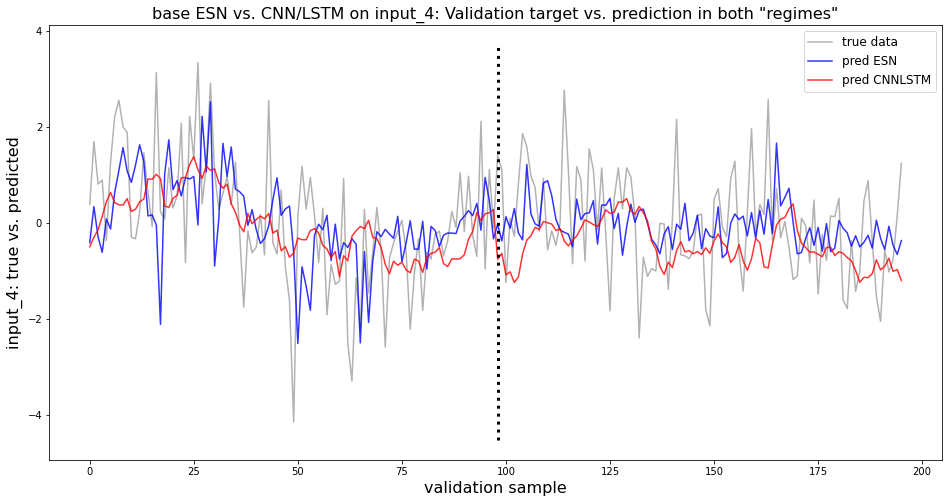

In [197]:
# Fidelity check: Plot true vs. predicted absolute values
plt.figure(figsize=(16,8))
plt.plot(range(len(val_target_ESN)),val_target_ESN,'k',label="true data", alpha=0.3)
plt.plot(range(len(val_pred_ESN)),val_pred_ESN,'b',  alpha=0.8, label='pred ESN')
plt.plot(range(len(val_pred_CNNLSTM)),val_pred_CNNLSTM,'r',  alpha=0.8, label='pred CNNLSTM')
plt.xlabel("validation sample", fontsize=16)
plt.ylabel("input_4: true vs. predicted", fontsize=16)

# Add vertical line separating both regimes, since we samples validation data from start and end
lo,hi = plt.ylim()
plt.plot([len(val_pred)/2,len(val_pred)/2],[lo+np.spacing(1),hi-np.spacing(1)],'k:', linewidth=3)

plt.title('base ESN vs. CNN/LSTM on input_4: Validation target vs. prediction in both "regimes"', fontsize=16)
plt.legend(fontsize=12)
plt.show()

### Multirun ESN on modified input_1 with varying noise level

In [37]:
# Set number of runs per noise level
n_runs = 20

# Set noise levels
noise_grid = np.linspace(0,2,21)
print("noise_grid: ", noise_grid)

# Get verbose function outputs:
verbose = False

# Set input and target parameters:
input_length = 10
target_length = 1
time_lag = 0
train_val_split = 0.8

# Work with unscaled absolute values:
abs_to_rel_YN = False
binary_YN = False
scaled_YN = False
abs_values_YN = True

# Set reservoir parameters:
n_res=100
sparsity=0.2
spectral_rad=1.2
w_in_lim=1.0
activation='sigmoid'

# Initialize arrays for storing accuracy and mae for each run for each parameter selection.
grid_accuracy = np.zeros((len(noise_grid), n_runs))
grid_mae = np.zeros((len(noise_grid), n_runs))

# Note runtime: Start
start = time.time()

# Loop over noise levels in noise_grid:
for i in range(len(noise_grid)):
    
    # Get current n_res
    noise = noise_grid[i]
    
    # Create input according to current noise level: 

    # Specify number of steps per regime.
    n_ = 1000

    # Specify input for sin function with linspace(start, stop, numsteps)
    t = np.linspace(0, 20*np.pi, n_) 
    
    # Set the one amplitude a1, and one base frequency f1
    a1 = 1
    f1 = 1

    # Set noise standard deviation parameter n1
    n1 = noise

    # Add noise with np.random.normal(mean, std, numsteps).
    input = a1 * np.sin(f1 * t) + np.random.normal(0, n1, n_)

    # Loop over number of runs:
    for run in range(n_runs):

        # print status:
        print("noise level : ", i+1, " of ", len(noise_grid), ", run: ", run+1, " of ", n_runs)

        # Create inputs and targets from absolute data
        train_input, val_input, train_target, val_target, train_min, train_max = split_data(input, 
                                                                                            input_length = input_length, 
                                                                                            target_length = target_length, 
                                                                                            time_lag=time_lag,
                                                                                            train_val_split=train_val_split, 
                                                                                            abs_to_rel_YN=abs_to_rel_YN,
                                                                                            binary_YN=binary_YN, 
                                                                                            scaled_YN=scaled_YN,
                                                                                            verbose=verbose)

        # Train base ESN.
        # Note: Third dimension in train_input shape is for time_lag. Have only one slice here.
        W_in, W_res, W_out = trainESN(train_input[:,:,0], train_target, 
                                      n_res=n_res, 
                                      sparsity=sparsity, 
                                      spectral_rad=spectral_rad, 
                                      w_in_lim=w_in_lim, 
                                      activation=activation, 
                                      verbose=verbose)

        # Get prediction on validation data and evaluation metrics
        val_target, val_pred, accuracy, mae = predESN(W_in, W_res, W_out, val_input[:,:,0], val_target, 
                                                      activation=activation,
                                                      abs_values_YN=abs_values_YN,
                                                      scaled_YN=scaled_YN, 
                                                      train_min=train_min, 
                                                      train_max=train_max, 
                                                      verbose=verbose)

        # Store accuracy and mae for current run for current parameter selection:
        grid_accuracy[i,run] = accuracy
        grid_mae[i,run] = mae

# Get runtime:
duration = time.time() - start
print("Total runtime: ", duration)

noise_grid:  [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2. ]
noise level :  1  of  21 , run:  1  of  20
noise level :  1  of  21 , run:  2  of  20
noise level :  1  of  21 , run:  3  of  20
noise level :  1  of  21 , run:  4  of  20
noise level :  1  of  21 , run:  5  of  20
noise level :  1  of  21 , run:  6  of  20
noise level :  1  of  21 , run:  7  of  20
noise level :  1  of  21 , run:  8  of  20
noise level :  1  of  21 , run:  9  of  20
noise level :  1  of  21 , run:  10  of  20
noise level :  1  of  21 , run:  11  of  20
noise level :  1  of  21 , run:  12  of  20
noise level :  1  of  21 , run:  13  of  20
noise level :  1  of  21 , run:  14  of  20
noise level :  1  of  21 , run:  15  of  20
noise level :  1  of  21 , run:  16  of  20
noise level :  1  of  21 , run:  17  of  20
noise level :  1  of  21 , run:  18  of  20
noise level :  1  of  21 , run:  19  of  20
noise level :  1  of  21 , run:  20  of  20
noise level :  2  of  21 , ru

noise level :  10  of  21 , run:  7  of  20
noise level :  10  of  21 , run:  8  of  20
noise level :  10  of  21 , run:  9  of  20
noise level :  10  of  21 , run:  10  of  20
noise level :  10  of  21 , run:  11  of  20
noise level :  10  of  21 , run:  12  of  20
noise level :  10  of  21 , run:  13  of  20
noise level :  10  of  21 , run:  14  of  20
noise level :  10  of  21 , run:  15  of  20
noise level :  10  of  21 , run:  16  of  20
noise level :  10  of  21 , run:  17  of  20
noise level :  10  of  21 , run:  18  of  20
noise level :  10  of  21 , run:  19  of  20
noise level :  10  of  21 , run:  20  of  20
noise level :  11  of  21 , run:  1  of  20
noise level :  11  of  21 , run:  2  of  20
noise level :  11  of  21 , run:  3  of  20
noise level :  11  of  21 , run:  4  of  20
noise level :  11  of  21 , run:  5  of  20
noise level :  11  of  21 , run:  6  of  20
noise level :  11  of  21 , run:  7  of  20
noise level :  11  of  21 , run:  8  of  20
noise level :  11  of

noise level :  19  of  21 , run:  11  of  20
noise level :  19  of  21 , run:  12  of  20
noise level :  19  of  21 , run:  13  of  20
noise level :  19  of  21 , run:  14  of  20
noise level :  19  of  21 , run:  15  of  20
noise level :  19  of  21 , run:  16  of  20
noise level :  19  of  21 , run:  17  of  20
noise level :  19  of  21 , run:  18  of  20
noise level :  19  of  21 , run:  19  of  20
noise level :  19  of  21 , run:  20  of  20
noise level :  20  of  21 , run:  1  of  20
noise level :  20  of  21 , run:  2  of  20
noise level :  20  of  21 , run:  3  of  20
noise level :  20  of  21 , run:  4  of  20
noise level :  20  of  21 , run:  5  of  20
noise level :  20  of  21 , run:  6  of  20
noise level :  20  of  21 , run:  7  of  20
noise level :  20  of  21 , run:  8  of  20
noise level :  20  of  21 , run:  9  of  20
noise level :  20  of  21 , run:  10  of  20
noise level :  20  of  21 , run:  11  of  20
noise level :  20  of  21 , run:  12  of  20
noise level :  20  

In [43]:
# Get mean accuracy and mean plus standard deviation of mae for grid over all runs:
mean_grid_accuracy = np.mean(grid_accuracy, axis=-1)
mean_grid_mae = np.mean(grid_mae, axis=-1)
std_grid_mae = np.std(grid_mae, axis=-1)

In [44]:
std_grid_mae

array([0.00013883, 0.00219895, 0.00523158, 0.00398498, 0.00780301,
       0.00820857, 0.00908424, 0.00757689, 0.01578409, 0.01416852,
       0.01550741, 0.01548611, 0.0227649 , 0.04111758, 0.02399778,
       0.02410812, 0.02019693, 0.02029682, 0.02861255, 0.02297017,
       0.04719513])

In [63]:
# Saved grid search result in hard-coded manner:
ESN_input1_mean_grid_accuracy = np.array([1.     , 0.50245, 0.42205, 0.4619 , 0.5115 , 0.5267 , 0.5008 ,
       0.4769 , 0.5294 , 0.533  , 0.54625, 0.5808 , 0.5651 , 0.55605,
       0.55585, 0.58625, 0.5497 , 0.52315, 0.5886 , 0.60205, 0.54795])
ESN_input1_mean_grid_mae = np.array([1.350000e-04, 9.714000e-02, 2.076550e-01, 2.874300e-01,
       3.834100e-01, 4.650200e-01, 5.667400e-01, 5.943150e-01,
       7.095600e-01, 8.021700e-01, 8.363900e-01, 9.934550e-01,
       1.134220e+00, 1.300820e+00, 1.272040e+00, 1.300805e+00,
       1.365310e+00, 1.482690e+00, 1.670600e+00, 1.626890e+00,
       1.683460e+00])
ESN_input1_std_grid_mae = np.array([0.00013883, 0.00219895, 0.00523158, 0.00398498, 0.00780301,
       0.00820857, 0.00908424, 0.00757689, 0.01578409, 0.01416852,
       0.01550741, 0.01548611, 0.0227649 , 0.04111758, 0.02399778,
       0.02410812, 0.02019693, 0.02029682, 0.02861255, 0.02297017,
       0.04719513])

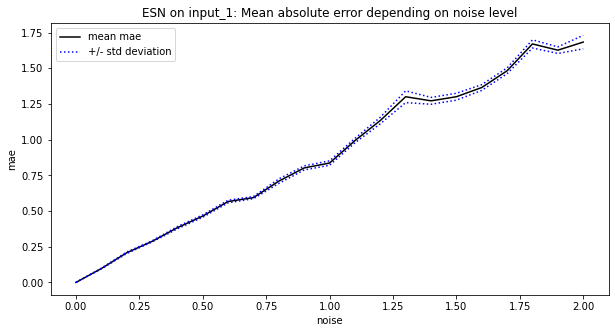

In [66]:
# Plot mean mae (with +/- std) over noise grid
fig, axes = plt.subplots(1, 1, figsize=(10,5))
axes.plot(noise_grid, ESN_input1_mean_grid_mae, color="k", label="mean mae")
axes.plot(noise_grid, ESN_input1_mean_grid_mae + ESN_input1_std_grid_mae, color="b", linestyle="dotted", label="+/- std deviation")
axes.plot(noise_grid, ESN_input1_mean_grid_mae - ESN_input1_std_grid_mae, color="b", linestyle="dotted")
axes.set_xlabel("noise")
axes.set_ylabel("mae")
axes.set_title("ESN on input_1: Mean absolute error depending on noise level")
axes.legend()
plt.show()

### Multirun ESN on modified input_2 with varying noise level

In [106]:
# Set number of runs per noise level
n_runs = 20

# Set noise levels
noise_grid = np.linspace(0,2,21)
print("noise_grid: ", noise_grid)

# Get verbose function outputs:
verbose = False

# Set input and target parameters:
input_length = 10
target_length = 1
time_lag = 0
train_val_split = 0.8
val_samples_from = 'start_end'

# Work with unscaled absolute values:
abs_to_rel_YN = False
binary_YN = False
scaled_YN = False
abs_values_YN = True

# Set reservoir parameters:
n_res=100
sparsity=0.2
spectral_rad=1.2
w_in_lim=1.0
activation='sigmoid'

# Initialize arrays for storing accuracy and mae for each run for each parameter selection.
grid_accuracy = np.zeros((len(noise_grid), n_runs))
grid_mae = np.zeros((len(noise_grid), n_runs))

# Note runtime: Start
start = time.time()

# Loop over noise levels in noise_grid:
for i in range(len(noise_grid)):
    
    # Get current n_res
    noise = noise_grid[i]
    
    # Create input according to current noise level: 

    # Specify number of steps per regime.
    n_ = 1000

    # Specify input for sin function with linspace(start, stop, numsteps)
    t = np.linspace(0, 20*np.pi, n_) 
    
    # Set the one amplitude a1, and two base frequencies f1 and f2
    a1 = 1
    f1 = 1
    f2 = 2

    # Set noise standard deviation parameter n1
    n1 = noise

    # Add noise with np.random.normal(mean, std, numsteps).
    input = np.concatenate((a1 * np.sin(f1 * t[:int(n_ / 2)]), a1 * np.sin(f2 * t[int(n_ / 2):]))) + np.random.normal(0, n1, n_)

    # Loop over number of runs:
    for run in range(n_runs):

        # print status:
        print("noise level : ", i+1, " of ", len(noise_grid), ", run: ", run+1, " of ", n_runs)

        # Create inputs and targets from absolute data
        train_input, val_input, train_target, val_target, train_min, train_max = split_data(input, 
                                                                                            input_length = input_length, 
                                                                                            target_length = target_length, 
                                                                                            time_lag=time_lag,
                                                                                            train_val_split=train_val_split, 
                                                                                            val_samples_from=val_samples_from,
                                                                                            abs_to_rel_YN=abs_to_rel_YN,
                                                                                            binary_YN=binary_YN, 
                                                                                            scaled_YN=scaled_YN,
                                                                                            verbose=verbose)

        # Train base ESN.
        # Note: Third dimension in train_input shape is for time_lag. Have only one slice here.
        W_in, W_res, W_out = trainESN(train_input[:,:,0], train_target, 
                                      n_res=n_res, 
                                      sparsity=sparsity, 
                                      spectral_rad=spectral_rad, 
                                      w_in_lim=w_in_lim, 
                                      activation=activation, 
                                      verbose=verbose)

        # Get prediction on validation data and evaluation metrics
        val_target, val_pred, accuracy, mae = predESN(W_in, W_res, W_out, val_input[:,:,0], val_target, 
                                                      activation=activation,
                                                      abs_values_YN=abs_values_YN,
                                                      scaled_YN=scaled_YN, 
                                                      train_min=train_min, 
                                                      train_max=train_max, 
                                                      verbose=verbose)

        # Store accuracy and mae for current run for current parameter selection:
        grid_accuracy[i,run] = accuracy
        grid_mae[i,run] = mae

# Get runtime:
duration = time.time() - start
print("Total runtime: ", duration)

noise_grid:  [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2. ]
noise level :  1  of  21 , run:  1  of  20
noise level :  1  of  21 , run:  2  of  20
noise level :  1  of  21 , run:  3  of  20
noise level :  1  of  21 , run:  4  of  20
noise level :  1  of  21 , run:  5  of  20
noise level :  1  of  21 , run:  6  of  20
noise level :  1  of  21 , run:  7  of  20
noise level :  1  of  21 , run:  8  of  20
noise level :  1  of  21 , run:  9  of  20
noise level :  1  of  21 , run:  10  of  20
noise level :  1  of  21 , run:  11  of  20
noise level :  1  of  21 , run:  12  of  20
noise level :  1  of  21 , run:  13  of  20
noise level :  1  of  21 , run:  14  of  20
noise level :  1  of  21 , run:  15  of  20
noise level :  1  of  21 , run:  16  of  20
noise level :  1  of  21 , run:  17  of  20
noise level :  1  of  21 , run:  18  of  20
noise level :  1  of  21 , run:  19  of  20
noise level :  1  of  21 , run:  20  of  20
noise level :  2  of  21 , ru

noise level :  10  of  21 , run:  7  of  20
noise level :  10  of  21 , run:  8  of  20
noise level :  10  of  21 , run:  9  of  20
noise level :  10  of  21 , run:  10  of  20
noise level :  10  of  21 , run:  11  of  20
noise level :  10  of  21 , run:  12  of  20
noise level :  10  of  21 , run:  13  of  20
noise level :  10  of  21 , run:  14  of  20
noise level :  10  of  21 , run:  15  of  20
noise level :  10  of  21 , run:  16  of  20
noise level :  10  of  21 , run:  17  of  20
noise level :  10  of  21 , run:  18  of  20
noise level :  10  of  21 , run:  19  of  20
noise level :  10  of  21 , run:  20  of  20
noise level :  11  of  21 , run:  1  of  20
noise level :  11  of  21 , run:  2  of  20
noise level :  11  of  21 , run:  3  of  20
noise level :  11  of  21 , run:  4  of  20
noise level :  11  of  21 , run:  5  of  20
noise level :  11  of  21 , run:  6  of  20
noise level :  11  of  21 , run:  7  of  20
noise level :  11  of  21 , run:  8  of  20
noise level :  11  of

noise level :  19  of  21 , run:  11  of  20
noise level :  19  of  21 , run:  12  of  20
noise level :  19  of  21 , run:  13  of  20
noise level :  19  of  21 , run:  14  of  20
noise level :  19  of  21 , run:  15  of  20
noise level :  19  of  21 , run:  16  of  20
noise level :  19  of  21 , run:  17  of  20
noise level :  19  of  21 , run:  18  of  20
noise level :  19  of  21 , run:  19  of  20
noise level :  19  of  21 , run:  20  of  20
noise level :  20  of  21 , run:  1  of  20
noise level :  20  of  21 , run:  2  of  20
noise level :  20  of  21 , run:  3  of  20
noise level :  20  of  21 , run:  4  of  20
noise level :  20  of  21 , run:  5  of  20
noise level :  20  of  21 , run:  6  of  20
noise level :  20  of  21 , run:  7  of  20
noise level :  20  of  21 , run:  8  of  20
noise level :  20  of  21 , run:  9  of  20
noise level :  20  of  21 , run:  10  of  20
noise level :  20  of  21 , run:  11  of  20
noise level :  20  of  21 , run:  12  of  20
noise level :  20  

In [107]:
# Get mean accuracy and mean plus standard deviation of mae for grid over all runs:
mean_grid_accuracy = np.mean(grid_accuracy, axis=-1)
mean_grid_mae = np.mean(grid_mae, axis=-1)
std_grid_mae = np.std(grid_mae, axis=-1)

In [110]:
std_grid_mae

array([0.00019046, 0.00129092, 0.00459038, 0.00698552, 0.01217735,
       0.01173216, 0.01270804, 0.00979486, 0.02122673, 0.01302171,
       0.01245182, 0.01051282, 0.02215927, 0.0183874 , 0.03017698,
       0.02034254, 0.02478151, 0.04324229, 0.03711063, 0.04558603,
       0.03541402])

In [111]:
# Saved grid search result in hard-coded manner:
ESN_input2_mean_grid_accuracy = np.array([1.     , 0.498  , 0.49245, 0.4987 , 0.5315 , 0.49075, 0.53865,
       0.52725, 0.5062 , 0.5019 , 0.56505, 0.4987 , 0.54825, 0.55715,
       0.553  , 0.53915, 0.61335, 0.59175, 0.57455, 0.58235, 0.55845])
ESN_input2_mean_grid_mae = np.array([3.150000e-04, 1.035550e-01, 2.015200e-01, 3.379550e-01,
       4.456750e-01, 5.122050e-01, 6.533850e-01, 5.739850e-01,
       7.941250e-01, 7.534900e-01, 8.954750e-01, 9.172450e-01,
       1.113885e+00, 1.182105e+00, 1.174515e+00, 1.390125e+00,
       1.337770e+00, 1.553460e+00, 1.685625e+00, 1.857900e+00,
       1.913855e+00])
ESN_input2_std_grid_mae = np.array([0.00019046, 0.00129092, 0.00459038, 0.00698552, 0.01217735,
       0.01173216, 0.01270804, 0.00979486, 0.02122673, 0.01302171,
       0.01245182, 0.01051282, 0.02215927, 0.0183874 , 0.03017698,
       0.02034254, 0.02478151, 0.04324229, 0.03711063, 0.04558603,
       0.03541402])

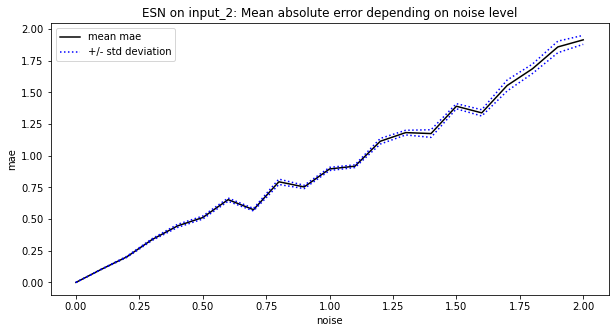

In [112]:
# Plot mean mae (with +/- std) over noise grid
fig, axes = plt.subplots(1, 1, figsize=(10,5))
axes.plot(noise_grid, ESN_input2_mean_grid_mae, color="k", label="mean mae")
axes.plot(noise_grid, ESN_input2_mean_grid_mae + ESN_input2_std_grid_mae, color="b", linestyle="dotted", label="+/- std deviation")
axes.plot(noise_grid, ESN_input2_mean_grid_mae - ESN_input2_std_grid_mae, color="b", linestyle="dotted")
axes.set_xlabel("noise")
axes.set_ylabel("mae")
axes.set_title("ESN on input_2: Mean absolute error depending on noise level")
axes.legend()
plt.show()

### Multirun ESN on modified input_3 with varying noise level

In [113]:
# Set number of runs per noise level
n_runs = 20

# Set noise levels
noise_grid = np.linspace(0,2,21)
print("noise_grid: ", noise_grid)

# Get verbose function outputs:
verbose = False

# Set input and target parameters:
input_length = 10
target_length = 1
time_lag = 0
train_val_split = 0.8
val_samples_from = 'start_end'

# Work with unscaled absolute values:
abs_to_rel_YN = False
binary_YN = False
scaled_YN = False
abs_values_YN = True

# Set reservoir parameters:
n_res=100
sparsity=0.2
spectral_rad=1.2
w_in_lim=1.0
activation='sigmoid'

# Initialize arrays for storing accuracy and mae for each run for each parameter selection.
grid_accuracy = np.zeros((len(noise_grid), n_runs))
grid_mae = np.zeros((len(noise_grid), n_runs))

# Note runtime: Start
start = time.time()

# Loop over noise levels in noise_grid:
for i in range(len(noise_grid)):
    
    # Get current n_res
    noise = noise_grid[i]
    
    # Create input according to current noise level: 

    # Specify number of steps per regime.
    n_ = 1000

    # Specify input for sin function with linspace(start, stop, numsteps)
    t = np.linspace(0, 20*np.pi, n_) 
        
    # Set the two amplitudes a1 and a2, and the one frequency f1
    a1 = 1
    a2 = 0.5
    f1 = 1

    # Set noise standard deviation parameter n1
    n1 = noise

    # Add noise with np.random.normal(mean, std, numsteps).
    input = np.concatenate((a1 * np.sin(f1 * t[:int(n_ / 2)]), a2 * np.sin(f1 * t[int(n_ / 2):]))) + np.random.normal(0, n1, n_)
    
    # Loop over number of runs:
    for run in range(n_runs):

        # print status:
        print("noise level : ", i+1, " of ", len(noise_grid), ", run: ", run+1, " of ", n_runs)

        # Create inputs and targets from absolute data
        train_input, val_input, train_target, val_target, train_min, train_max = split_data(input, 
                                                                                            input_length = input_length, 
                                                                                            target_length = target_length, 
                                                                                            time_lag=time_lag,
                                                                                            train_val_split=train_val_split, 
                                                                                            val_samples_from=val_samples_from,
                                                                                            abs_to_rel_YN=abs_to_rel_YN,
                                                                                            binary_YN=binary_YN, 
                                                                                            scaled_YN=scaled_YN,
                                                                                            verbose=verbose)

        # Train base ESN.
        # Note: Third dimension in train_input shape is for time_lag. Have only one slice here.
        W_in, W_res, W_out = trainESN(train_input[:,:,0], train_target, 
                                      n_res=n_res, 
                                      sparsity=sparsity, 
                                      spectral_rad=spectral_rad, 
                                      w_in_lim=w_in_lim, 
                                      activation=activation, 
                                      verbose=verbose)

        # Get prediction on validation data and evaluation metrics
        val_target, val_pred, accuracy, mae = predESN(W_in, W_res, W_out, val_input[:,:,0], val_target, 
                                                      activation=activation,
                                                      abs_values_YN=abs_values_YN,
                                                      scaled_YN=scaled_YN, 
                                                      train_min=train_min, 
                                                      train_max=train_max, 
                                                      verbose=verbose)

        # Store accuracy and mae for current run for current parameter selection:
        grid_accuracy[i,run] = accuracy
        grid_mae[i,run] = mae

# Get runtime:
duration = time.time() - start
print("Total runtime: ", duration)

noise_grid:  [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2. ]
noise level :  1  of  21 , run:  1  of  20
noise level :  1  of  21 , run:  2  of  20
noise level :  1  of  21 , run:  3  of  20
noise level :  1  of  21 , run:  4  of  20
noise level :  1  of  21 , run:  5  of  20
noise level :  1  of  21 , run:  6  of  20
noise level :  1  of  21 , run:  7  of  20
noise level :  1  of  21 , run:  8  of  20
noise level :  1  of  21 , run:  9  of  20
noise level :  1  of  21 , run:  10  of  20
noise level :  1  of  21 , run:  11  of  20
noise level :  1  of  21 , run:  12  of  20
noise level :  1  of  21 , run:  13  of  20
noise level :  1  of  21 , run:  14  of  20
noise level :  1  of  21 , run:  15  of  20
noise level :  1  of  21 , run:  16  of  20
noise level :  1  of  21 , run:  17  of  20
noise level :  1  of  21 , run:  18  of  20
noise level :  1  of  21 , run:  19  of  20
noise level :  1  of  21 , run:  20  of  20
noise level :  2  of  21 , ru

noise level :  10  of  21 , run:  7  of  20
noise level :  10  of  21 , run:  8  of  20
noise level :  10  of  21 , run:  9  of  20
noise level :  10  of  21 , run:  10  of  20
noise level :  10  of  21 , run:  11  of  20
noise level :  10  of  21 , run:  12  of  20
noise level :  10  of  21 , run:  13  of  20
noise level :  10  of  21 , run:  14  of  20
noise level :  10  of  21 , run:  15  of  20
noise level :  10  of  21 , run:  16  of  20
noise level :  10  of  21 , run:  17  of  20
noise level :  10  of  21 , run:  18  of  20
noise level :  10  of  21 , run:  19  of  20
noise level :  10  of  21 , run:  20  of  20
noise level :  11  of  21 , run:  1  of  20
noise level :  11  of  21 , run:  2  of  20
noise level :  11  of  21 , run:  3  of  20
noise level :  11  of  21 , run:  4  of  20
noise level :  11  of  21 , run:  5  of  20
noise level :  11  of  21 , run:  6  of  20
noise level :  11  of  21 , run:  7  of  20
noise level :  11  of  21 , run:  8  of  20
noise level :  11  of

noise level :  19  of  21 , run:  11  of  20
noise level :  19  of  21 , run:  12  of  20
noise level :  19  of  21 , run:  13  of  20
noise level :  19  of  21 , run:  14  of  20
noise level :  19  of  21 , run:  15  of  20
noise level :  19  of  21 , run:  16  of  20
noise level :  19  of  21 , run:  17  of  20
noise level :  19  of  21 , run:  18  of  20
noise level :  19  of  21 , run:  19  of  20
noise level :  19  of  21 , run:  20  of  20
noise level :  20  of  21 , run:  1  of  20
noise level :  20  of  21 , run:  2  of  20
noise level :  20  of  21 , run:  3  of  20
noise level :  20  of  21 , run:  4  of  20
noise level :  20  of  21 , run:  5  of  20
noise level :  20  of  21 , run:  6  of  20
noise level :  20  of  21 , run:  7  of  20
noise level :  20  of  21 , run:  8  of  20
noise level :  20  of  21 , run:  9  of  20
noise level :  20  of  21 , run:  10  of  20
noise level :  20  of  21 , run:  11  of  20
noise level :  20  of  21 , run:  12  of  20
noise level :  20  

In [114]:
# Get mean accuracy and mean plus standard deviation of mae for grid over all runs:
mean_grid_accuracy = np.mean(grid_accuracy, axis=-1)
mean_grid_mae = np.mean(grid_mae, axis=-1)
std_grid_mae = np.std(grid_mae, axis=-1)

In [117]:
std_grid_mae

array([0.0001337 , 0.00170214, 0.00316873, 0.0059309 , 0.0105765 ,
       0.00737127, 0.01439067, 0.0138426 , 0.01550339, 0.01583946,
       0.03167958, 0.01209053, 0.04950903, 0.01605806, 0.02214446,
       0.02712203, 0.02614417, 0.01991607, 0.03976914, 0.03980359,
       0.03148802])

In [118]:
# Saved grid search result in hard-coded manner:
ESN_input3_mean_grid_accuracy = np.array([1.     , 0.48045, 0.45955, 0.45865, 0.50135, 0.5115 , 0.5088 ,
       0.55095, 0.5568 , 0.5274 , 0.57815, 0.5365 , 0.59425, 0.5713 ,
       0.6108 , 0.57255, 0.6038 , 0.5957 , 0.629  , 0.59215, 0.60575])
ESN_input3_mean_grid_mae = np.array([2.750000e-04, 9.428500e-02, 1.947750e-01, 2.687200e-01,
       4.112400e-01, 4.096800e-01, 5.280650e-01, 5.975950e-01,
       7.081700e-01, 8.057550e-01, 1.028255e+00, 8.844100e-01,
       1.094240e+00, 1.129635e+00, 1.158065e+00, 1.363150e+00,
       1.320550e+00, 1.363025e+00, 1.669385e+00, 1.560545e+00,
       1.724895e+00])
ESN_input3_std_grid_mae = np.array([0.0001337 , 0.00170214, 0.00316873, 0.0059309 , 0.0105765 ,
       0.00737127, 0.01439067, 0.0138426 , 0.01550339, 0.01583946,
       0.03167958, 0.01209053, 0.04950903, 0.01605806, 0.02214446,
       0.02712203, 0.02614417, 0.01991607, 0.03976914, 0.03980359,
       0.03148802])

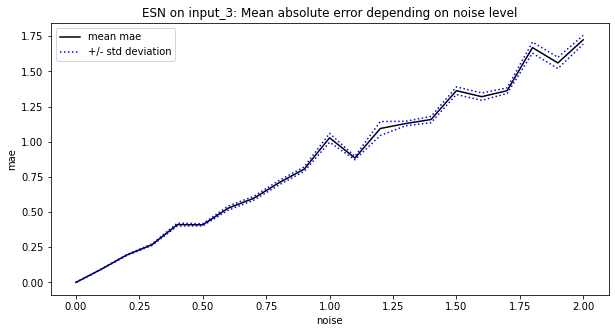

In [119]:
# Plot mean mae (with +/- std) over noise grid
fig, axes = plt.subplots(1, 1, figsize=(10,5))
axes.plot(noise_grid, ESN_input3_mean_grid_mae, color="k", label="mean mae")
axes.plot(noise_grid, ESN_input3_mean_grid_mae + ESN_input3_std_grid_mae, color="b", linestyle="dotted", label="+/- std deviation")
axes.plot(noise_grid, ESN_input3_mean_grid_mae - ESN_input3_std_grid_mae, color="b", linestyle="dotted")
axes.set_xlabel("noise")
axes.set_ylabel("mae")
axes.set_title("ESN on input_3: Mean absolute error depending on noise level")
axes.legend()
plt.show()

### Multirun ESN on modified input_4 with varying noise level

In [120]:
# Set number of runs per noise level
n_runs = 20

# Set noise levels
noise_grid = np.linspace(0,2,21)
print("noise_grid: ", noise_grid)

# Get verbose function outputs:
verbose = False

# Set input and target parameters:
input_length = 10
target_length = 1
time_lag = 0
train_val_split = 0.8
val_samples_from = 'start_end'

# Work with unscaled absolute values:
abs_to_rel_YN = False
binary_YN = False
scaled_YN = False
abs_values_YN = True

# Set reservoir parameters:
n_res=100
sparsity=0.2
spectral_rad=1.2
w_in_lim=1.0
activation='sigmoid'

# Initialize arrays for storing accuracy and mae for each run for each parameter selection.
grid_accuracy = np.zeros((len(noise_grid), n_runs))
grid_mae = np.zeros((len(noise_grid), n_runs))

# Note runtime: Start
start = time.time()

# Loop over noise levels in noise_grid:
for i in range(len(noise_grid)):
    
    # Get current n_res
    noise = noise_grid[i]
    
    # Create input according to current noise level: 

    # Specify number of steps per regime.
    n_ = 1000

    # Specify input for sin function with linspace(start, stop, numsteps)
    t = np.linspace(0, 20*np.pi, n_) 
    
    # Set the two amplitudes a1 and a2, and the two frequencies f1, f2
    a1 = 1
    a2 = 0.5
    f1 = 1
    f2 = 2

    # Set noise standard deviation parameter n1
    n1 = noise

    # Add noise with np.random.normal(mean, std, numsteps).
    input = np.concatenate((a1 * np.sin(f1 * t[:int(n_ / 2)]), a2 * np.sin(f2 * t[int(n_ / 2):]))) + np.random.normal(0, n1, n_)


    # Loop over number of runs:
    for run in range(n_runs):

        # print status:
        print("noise level : ", i+1, " of ", len(noise_grid), ", run: ", run+1, " of ", n_runs)

        # Create inputs and targets from absolute data
        train_input, val_input, train_target, val_target, train_min, train_max = split_data(input, 
                                                                                            input_length = input_length, 
                                                                                            target_length = target_length, 
                                                                                            time_lag=time_lag,
                                                                                            train_val_split=train_val_split, 
                                                                                            val_samples_from=val_samples_from,
                                                                                            abs_to_rel_YN=abs_to_rel_YN,
                                                                                            binary_YN=binary_YN, 
                                                                                            scaled_YN=scaled_YN,
                                                                                            verbose=verbose)

        # Train base ESN.
        # Note: Third dimension in train_input shape is for time_lag. Have only one slice here.
        W_in, W_res, W_out = trainESN(train_input[:,:,0], train_target, 
                                      n_res=n_res, 
                                      sparsity=sparsity, 
                                      spectral_rad=spectral_rad, 
                                      w_in_lim=w_in_lim, 
                                      activation=activation, 
                                      verbose=verbose)

        # Get prediction on validation data and evaluation metrics
        val_target, val_pred, accuracy, mae = predESN(W_in, W_res, W_out, val_input[:,:,0], val_target, 
                                                      activation=activation,
                                                      abs_values_YN=abs_values_YN,
                                                      scaled_YN=scaled_YN, 
                                                      train_min=train_min, 
                                                      train_max=train_max, 
                                                      verbose=verbose)

        # Store accuracy and mae for current run for current parameter selection:
        grid_accuracy[i,run] = accuracy
        grid_mae[i,run] = mae

# Get runtime:
duration = time.time() - start
print("Total runtime: ", duration)

noise_grid:  [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2. ]
noise level :  1  of  21 , run:  1  of  20
noise level :  1  of  21 , run:  2  of  20
noise level :  1  of  21 , run:  3  of  20
noise level :  1  of  21 , run:  4  of  20
noise level :  1  of  21 , run:  5  of  20
noise level :  1  of  21 , run:  6  of  20
noise level :  1  of  21 , run:  7  of  20
noise level :  1  of  21 , run:  8  of  20
noise level :  1  of  21 , run:  9  of  20
noise level :  1  of  21 , run:  10  of  20
noise level :  1  of  21 , run:  11  of  20
noise level :  1  of  21 , run:  12  of  20
noise level :  1  of  21 , run:  13  of  20
noise level :  1  of  21 , run:  14  of  20
noise level :  1  of  21 , run:  15  of  20
noise level :  1  of  21 , run:  16  of  20
noise level :  1  of  21 , run:  17  of  20
noise level :  1  of  21 , run:  18  of  20
noise level :  1  of  21 , run:  19  of  20
noise level :  1  of  21 , run:  20  of  20
noise level :  2  of  21 , ru

noise level :  10  of  21 , run:  7  of  20
noise level :  10  of  21 , run:  8  of  20
noise level :  10  of  21 , run:  9  of  20
noise level :  10  of  21 , run:  10  of  20
noise level :  10  of  21 , run:  11  of  20
noise level :  10  of  21 , run:  12  of  20
noise level :  10  of  21 , run:  13  of  20
noise level :  10  of  21 , run:  14  of  20
noise level :  10  of  21 , run:  15  of  20
noise level :  10  of  21 , run:  16  of  20
noise level :  10  of  21 , run:  17  of  20
noise level :  10  of  21 , run:  18  of  20
noise level :  10  of  21 , run:  19  of  20
noise level :  10  of  21 , run:  20  of  20
noise level :  11  of  21 , run:  1  of  20
noise level :  11  of  21 , run:  2  of  20
noise level :  11  of  21 , run:  3  of  20
noise level :  11  of  21 , run:  4  of  20
noise level :  11  of  21 , run:  5  of  20
noise level :  11  of  21 , run:  6  of  20
noise level :  11  of  21 , run:  7  of  20
noise level :  11  of  21 , run:  8  of  20
noise level :  11  of

noise level :  19  of  21 , run:  11  of  20
noise level :  19  of  21 , run:  12  of  20
noise level :  19  of  21 , run:  13  of  20
noise level :  19  of  21 , run:  14  of  20
noise level :  19  of  21 , run:  15  of  20
noise level :  19  of  21 , run:  16  of  20
noise level :  19  of  21 , run:  17  of  20
noise level :  19  of  21 , run:  18  of  20
noise level :  19  of  21 , run:  19  of  20
noise level :  19  of  21 , run:  20  of  20
noise level :  20  of  21 , run:  1  of  20
noise level :  20  of  21 , run:  2  of  20
noise level :  20  of  21 , run:  3  of  20
noise level :  20  of  21 , run:  4  of  20
noise level :  20  of  21 , run:  5  of  20
noise level :  20  of  21 , run:  6  of  20
noise level :  20  of  21 , run:  7  of  20
noise level :  20  of  21 , run:  8  of  20
noise level :  20  of  21 , run:  9  of  20
noise level :  20  of  21 , run:  10  of  20
noise level :  20  of  21 , run:  11  of  20
noise level :  20  of  21 , run:  12  of  20
noise level :  20  

In [121]:
# Get mean accuracy and mean plus standard deviation of mae for grid over all runs:
mean_grid_accuracy = np.mean(grid_accuracy, axis=-1)
mean_grid_mae = np.mean(grid_mae, axis=-1)
std_grid_mae = np.std(grid_mae, axis=-1)

In [124]:
std_grid_mae

array([0.00014654, 0.00133352, 0.0026786 , 0.00532644, 0.00574488,
       0.01191033, 0.00765218, 0.01448373, 0.01974607, 0.0265636 ,
       0.02178282, 0.02223498, 0.02048089, 0.02812374, 0.02072162,
       0.02305967, 0.03432714, 0.03713113, 0.03946731, 0.02711343,
       0.03695814])

In [125]:
# Saved grid search result in hard-coded manner:
ESN_input4_mean_grid_accuracy = np.array([1.     , 0.5034 , 0.41065, 0.4475 , 0.45205, 0.53195, 0.526  ,
       0.49995, 0.5372 , 0.57205, 0.5905 , 0.589  , 0.61875, 0.5949 ,
       0.56   , 0.59445, 0.6547 , 0.62495, 0.6041 , 0.60575, 0.5865 ])
ESN_input4_mean_grid_mae = np.array([2.050000e-04, 1.043150e-01, 2.049900e-01, 2.765000e-01,
       3.821200e-01, 5.155250e-01, 5.173100e-01, 6.698600e-01,
       8.116850e-01, 9.027900e-01, 1.012460e+00, 1.029895e+00,
       1.058900e+00, 1.267790e+00, 1.277050e+00, 1.246020e+00,
       1.447605e+00, 1.438655e+00, 1.730945e+00, 1.747870e+00,
       1.824235e+00])
ESN_input4_std_grid_mae = np.array([0.00014654, 0.00133352, 0.0026786 , 0.00532644, 0.00574488,
       0.01191033, 0.00765218, 0.01448373, 0.01974607, 0.0265636 ,
       0.02178282, 0.02223498, 0.02048089, 0.02812374, 0.02072162,
       0.02305967, 0.03432714, 0.03713113, 0.03946731, 0.02711343,
       0.03695814])

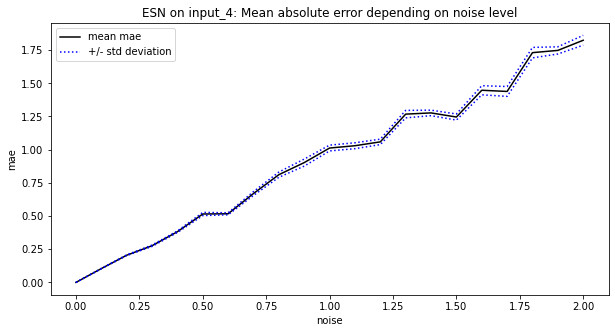

In [126]:
# Plot mean mae (with +/- std) over noise grid
fig, axes = plt.subplots(1, 1, figsize=(10,5))
axes.plot(noise_grid, ESN_input4_mean_grid_mae, color="k", label="mean mae")
axes.plot(noise_grid, ESN_input4_mean_grid_mae + ESN_input4_std_grid_mae, color="b", linestyle="dotted", label="+/- std deviation")
axes.plot(noise_grid, ESN_input4_mean_grid_mae - ESN_input4_std_grid_mae, color="b", linestyle="dotted")
axes.set_xlabel("noise")
axes.set_ylabel("mae")
axes.set_title("ESN on input_4: Mean absolute error depending on noise level")
axes.legend()
plt.show()

### Single run for CNN/LSTM on input_1

raw data shape:  (1000,)
train_input shape:  (787, 16, 1)
val_input shape:  (197, 16, 1)
train_target shape:  (787,)
val_target shape:  (197,)
train_min:  -2.2878059615306787
train_max:  2.402746051300502


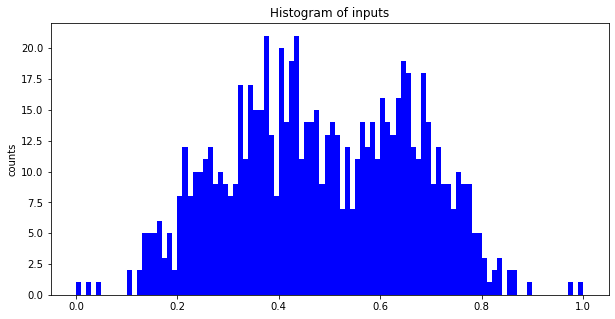

In [35]:
# Get verbose function outputs:
verbose = True

# Set input and target parameters:
input_length = 16
target_length = 1
time_lag = 0
train_val_split = 0.8

# Work with scaled absolute values:
abs_to_rel_YN = False
binary_YN = False
scaled_YN = True
abs_values_YN = True

# Create inputs and targets from absolute data
train_input, val_input, train_target, val_target, train_min, train_max = split_data(input_1, 
                                                                                    input_length = input_length, 
                                                                                    target_length = target_length, 
                                                                                    time_lag=time_lag,
                                                                                    train_val_split=train_val_split, 
                                                                                    abs_to_rel_YN=abs_to_rel_YN,
                                                                                    binary_YN=binary_YN, 
                                                                                    scaled_YN=scaled_YN,
                                                                                    verbose=verbose)

# check distribution of input values
nBins = 100
fig, axes = plt.subplots(1, 1, figsize=(10,5))
axes.hist(train_input[:,0], nBins, color="blue")
axes.set_ylabel("counts")
axes.set_title("Histogram of inputs")
plt.show()

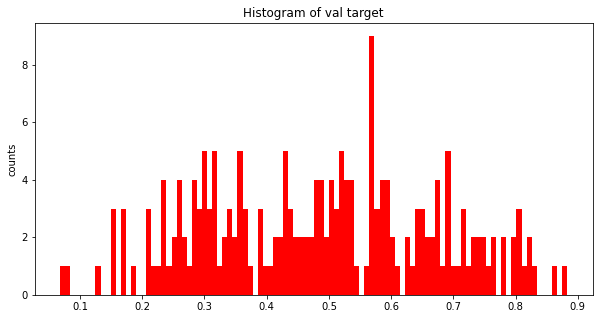

In [36]:
# check distribution of val targets
nBins = 100
fig, axes = plt.subplots(1, 1, figsize=(10,5))
axes.hist(val_target, nBins, color="red")
axes.set_ylabel("counts")
axes.set_title("Histogram of val target")
plt.show()

In [37]:
### Preparing CNN/LSTM model setup

# number of input features
num_channels = 1

# input dimensions
input_shape = (np.shape(train_input)[1], num_channels)    
num_inputs = train_input.shape[1] * num_channels
num_outputs = 1 

# further parameters: weight/bias initialization
weight_init = tfi.glorot_uniform() # tfi.RandomUniform(minval=-0.05, maxval=0.05, seed=None)  tfi.RandomNormal()
bias_init = tfi.Zeros()

# further parameters: regularization
kernel_reg_CNN=tfr.l1_l2(l1=0, l2=0) # (l1=1e-5, l2=1e-4)
bias_reg_CNN=tfr.l2(0) # l2(1e-4) 
kernel_reg_LSTM=tfr.l1_l2(l1=0, l2=0) # (l1=1e-5, l2=1e-4)
bias_reg_LSTM=tfr.l2(0) # l2(1e-4) 
kernel_reg_Dense=tfr.l1_l2(l1=0, l2=0) # (l1=1e-5, l2=1e-4)
bias_reg_Dense=tfr.l2(0) # l2(1e-4) 

# batch size
batch_size = 20  

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_80 (Conv1D)           (None, 10, 10)            80        
_________________________________________________________________
batch_normalization_80 (Batc (None, 10, 10)            40        
_________________________________________________________________
leaky_re_lu_80 (LeakyReLU)   (None, 10, 10)            0         
_________________________________________________________________
conv1d_81 (Conv1D)           (None, 7, 20)             820       
_________________________________________________________________
batch_normalization_81 (Batc (None, 7, 20)             80        
_________________________________________________________________
leaky_re_lu_81 (LeakyReLU)   (None, 7, 20)             0         
_________________________________________________________________
lstm_79 (LSTM)               (None, 7, 20)           

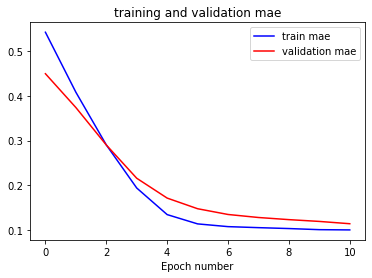

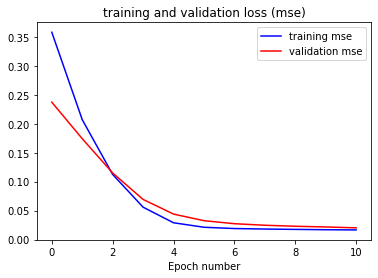

In [38]:
#########################################
# define model: hybrid CNN-LSTM         #
#########################################

model = Sequential()
model.add(Conv1D(filters=10, kernel_size=7, input_shape=input_shape, strides=1, kernel_initializer=weight_init, bias_initializer = bias_init, kernel_regularizer=kernel_reg_CNN, bias_regularizer=bias_reg_CNN))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.3))
model.add(Conv1D(filters=20, kernel_size=4, strides=1, kernel_initializer=weight_init, bias_initializer = bias_init, kernel_regularizer=kernel_reg_CNN, bias_regularizer=bias_reg_CNN))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.3))
model.add(LSTM(20, bias_initializer="zeros", return_sequences=True, kernel_regularizer=kernel_reg_LSTM, bias_regularizer=bias_reg_LSTM))
#model.add(Dropout(0.5))
model.add(LSTM(10, kernel_regularizer=kernel_reg_LSTM, bias_regularizer=bias_reg_LSTM))
#model.add(Dropout(0.5))
model.add(Dense(units=num_outputs, name = "output", activation = 'linear', kernel_initializer=weight_init, bias_initializer = bias_init, kernel_regularizer=kernel_reg_Dense, bias_regularizer=bias_reg_Dense))

# compile model (with constant lr)
model.compile(optimizer=Adam(learning_rate=0.0001),loss='mean_squared_error',metrics=['mae'])
model.summary()

# train model
history = model.fit(train_input, train_target, epochs=11, batch_size=batch_size, shuffle=True, verbose=1, validation_data=(val_input, val_target))

# plot train and validation mae
plt.plot(history.history['mae'], color = 'blue', label = 'train mae')
plt.plot(history.history['val_mae'], color = 'red', label = 'validation mae')
plt.xlabel('Epoch number')
plt.title('training and validation mae')
plt.legend()
plt.show()
    
# plot train and val_loss
plt.plot(history.history['loss'], color = 'blue', label = 'training mse')
plt.plot(history.history['val_loss'], color = 'red', label = 'validation mse')
plt.xlabel('Epoch number')
plt.title('training and validation loss (mse)')
plt.legend()
plt.show()  

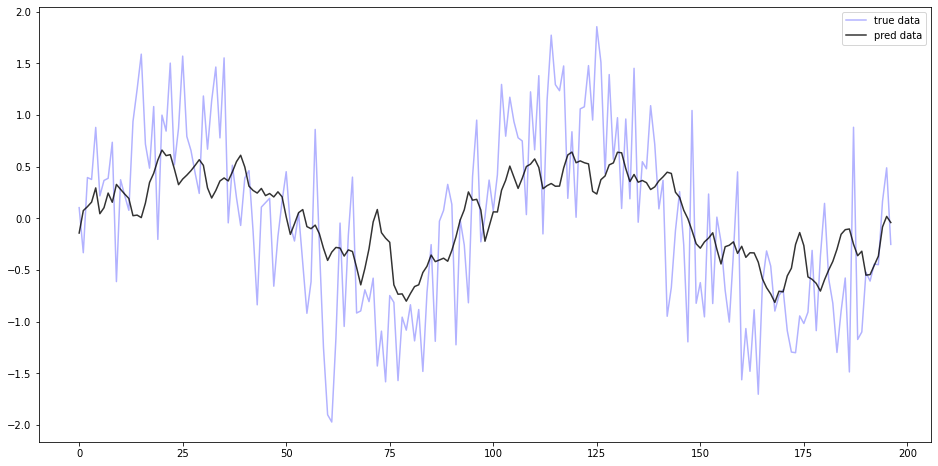

val_input shape:  (197, 16, 1)
val_target shape:  (197,)
val_pred shape:  (197,)
up movements percentage in val_target:  0.393
ESN pred. accuracy:  0.51
ESN mean abs. error:  0.5381


In [39]:
# Get prediction on validation data and evaluation metrics
val_target, val_pred, accuracy, mae = predCNNLSTM(val_input, val_target,
                                                  model,
                                                  target_length=target_length,
                                                  abs_values_YN=abs_values_YN,
                                                  scaled_YN=scaled_YN, 
                                                  train_min=train_min, 
                                                  train_max=train_max, 
                                                  abs_base=1.0,
                                                  verbose=verbose)

### Single run for CNN/LSTM on either: input_2, input_3 or input_4

All of these series encounter two different "regimes" and validation samples are taken from 'start' and 'end' of all samples, opposed to input_1.

raw data shape:  (1000,)
train_input shape:  (788, 16, 1)
val_input shape:  (196, 16, 1)
train_target shape:  (788,)
val_target shape:  (196,)
train_min:  -3.7643726789545893
train_max:  3.7552808956501007


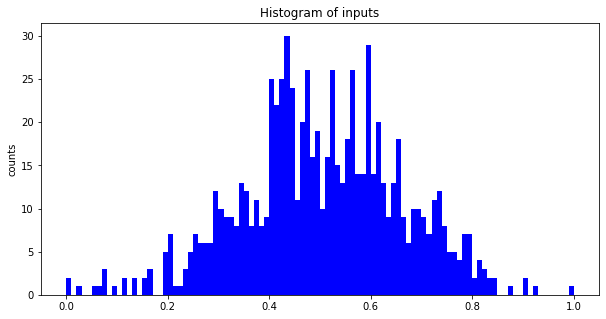

In [181]:
# Specify input series from input_2, _3 or _4, defined at the beginning of notebook!
input = input_4

# Note: Different input series need different number of epochs for training. Set parameter below!
# input_4 requires 16 epochs, while for the other input series 12 epochs are sufficient (empirically observed).

# Get verbose function outputs:
verbose = True

# Set input and target parameters:
input_length = 16
target_length = 1
time_lag = 0
train_val_split = 0.8
val_samples_from = 'start_end'

# Work with scaled absolute values:
abs_to_rel_YN = False
binary_YN = False
scaled_YN = True
abs_values_YN = True

# Create inputs and targets from absolute data
train_input, val_input, train_target, val_target, train_min, train_max = split_data(input, 
                                                                                    input_length = input_length, 
                                                                                    target_length = target_length, 
                                                                                    time_lag=time_lag,
                                                                                    train_val_split=train_val_split, 
                                                                                    val_samples_from=val_samples_from,
                                                                                    abs_to_rel_YN=abs_to_rel_YN,
                                                                                    binary_YN=binary_YN, 
                                                                                    scaled_YN=scaled_YN,
                                                                                    verbose=verbose)

# check distribution of input values
nBins = 100
fig, axes = plt.subplots(1, 1, figsize=(10,5))
axes.hist(train_input[:,0], nBins, color="blue")
axes.set_ylabel("counts")
axes.set_title("Histogram of inputs")
plt.show()

In [182]:
### Preparing CNN/LSTM model setup

# number of input features
num_channels = 1

# input dimensions
input_shape = (np.shape(train_input)[1], num_channels)    
num_inputs = train_input.shape[1] * num_channels
num_outputs = 1 

# further parameters: weight/bias initialization
weight_init = tfi.glorot_uniform() # tfi.RandomUniform(minval=-0.05, maxval=0.05, seed=None)  tfi.RandomNormal()
bias_init = tfi.Zeros()

# further parameters: regularization
kernel_reg_CNN=tfr.l1_l2(l1=0, l2=0) # (l1=1e-5, l2=1e-4)
bias_reg_CNN=tfr.l2(0) # l2(1e-4) 
kernel_reg_LSTM=tfr.l1_l2(l1=0, l2=0) # (l1=1e-5, l2=1e-4)
bias_reg_LSTM=tfr.l2(0) # l2(1e-4) 
kernel_reg_Dense=tfr.l1_l2(l1=0, l2=0) # (l1=1e-5, l2=1e-4)
bias_reg_Dense=tfr.l2(0) # l2(1e-4) 

# batch size and number of epochs
batch_size = 20  
epochs = 16

Model: "sequential_237"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_474 (Conv1D)          (None, 10, 10)            80        
_________________________________________________________________
batch_normalization_474 (Bat (None, 10, 10)            40        
_________________________________________________________________
leaky_re_lu_474 (LeakyReLU)  (None, 10, 10)            0         
_________________________________________________________________
conv1d_475 (Conv1D)          (None, 7, 20)             820       
_________________________________________________________________
batch_normalization_475 (Bat (None, 7, 20)             80        
_________________________________________________________________
leaky_re_lu_475 (LeakyReLU)  (None, 7, 20)             0         
_________________________________________________________________
lstm_474 (LSTM)              (None, 7, 20)          

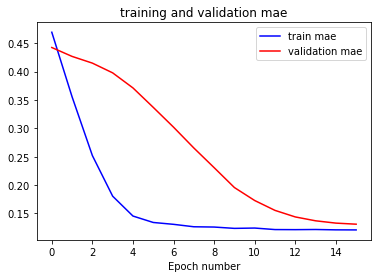

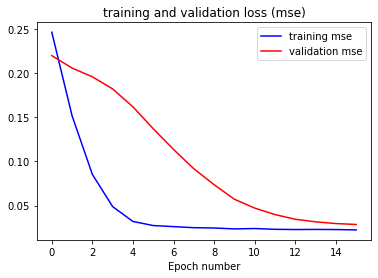

In [183]:
#########################################
# define model: hybrid CNN-LSTM         #
#########################################

model = Sequential()
model.add(Conv1D(filters=10, kernel_size=7, input_shape=input_shape, strides=1, kernel_initializer=weight_init, bias_initializer = bias_init, kernel_regularizer=kernel_reg_CNN, bias_regularizer=bias_reg_CNN))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.3))
model.add(Conv1D(filters=20, kernel_size=4, strides=1, kernel_initializer=weight_init, bias_initializer = bias_init, kernel_regularizer=kernel_reg_CNN, bias_regularizer=bias_reg_CNN))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.3))
model.add(LSTM(20, bias_initializer="zeros", return_sequences=True, kernel_regularizer=kernel_reg_LSTM, bias_regularizer=bias_reg_LSTM))
#model.add(Dropout(0.5))
model.add(LSTM(10, kernel_regularizer=kernel_reg_LSTM, bias_regularizer=bias_reg_LSTM))
#model.add(Dropout(0.5))
model.add(Dense(units=num_outputs, name = "output", activation = 'linear', kernel_initializer=weight_init, bias_initializer = bias_init, kernel_regularizer=kernel_reg_Dense, bias_regularizer=bias_reg_Dense))

# compile model (with constant lr)
model.compile(optimizer=Adam(learning_rate=0.0001),loss='mean_squared_error',metrics=['mae'])
model.summary()

# train model
history = model.fit(train_input, train_target, epochs=epochs, batch_size=batch_size, shuffle=True, verbose=1, validation_data=(val_input, val_target))

# plot train and validation mae
plt.plot(history.history['mae'], color = 'blue', label = 'train mae')
plt.plot(history.history['val_mae'], color = 'red', label = 'validation mae')
plt.xlabel('Epoch number')
plt.title('training and validation mae')
plt.legend()
plt.show()
    
# plot train and val_loss
plt.plot(history.history['loss'], color = 'blue', label = 'training mse')
plt.plot(history.history['val_loss'], color = 'red', label = 'validation mse')
plt.xlabel('Epoch number')
plt.title('training and validation loss (mse)')
plt.legend()
plt.show()  

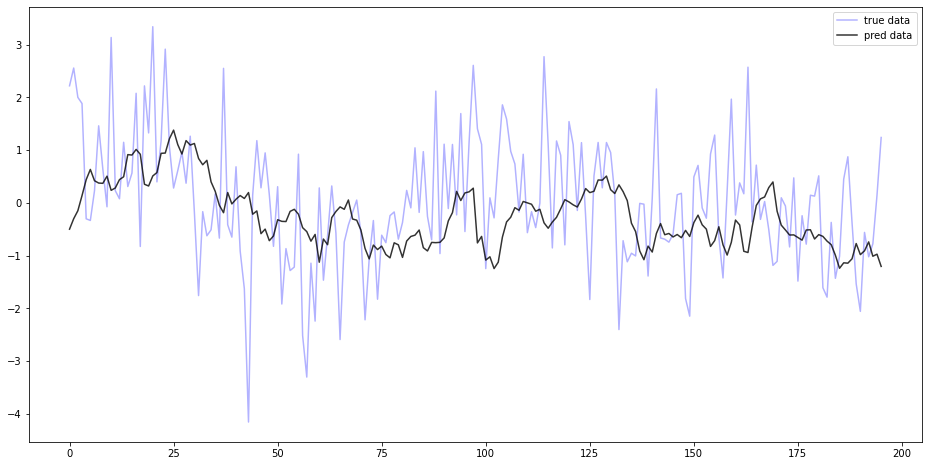

val_input shape:  (196, 16, 1)
val_target shape:  (196,)
val_pred shape:  (196,)
up movements percentage in val_target:  0.308
ESN pred. accuracy:  0.549
ESN mean abs. error:  0.9848


In [184]:
# Get prediction on validation data and evaluation metrics
val_target, val_pred, accuracy, mae = predCNNLSTM(val_input, val_target,
                                                  model,
                                                  target_length=target_length,
                                                  abs_values_YN=abs_values_YN,
                                                  scaled_YN=scaled_YN, 
                                                  train_min=train_min, 
                                                  train_max=train_max, 
                                                  abs_base=1.0,
                                                  verbose=verbose)

### Multirun CNN/LSTM on modified input_1 with varying noise level

Differences to multirun ESN:

* CNN/LSTM works with slightly longer input length: 16 days
* And CNN/LSTM works best with scaled absolute values, whereas ESN's performance doesn't depend on scaling.

In [40]:
# Set number of runs per noise level
n_runs = 10

# Set noise levels
noise_grid = np.linspace(0,2,21)
print("noise_grid: ", noise_grid)

# Get verbose function outputs:
verbose = False

# Set input and target parameters:
input_length = 16
target_length = 1
time_lag = 0
train_val_split = 0.8

# Work with unscaled absolute values:
abs_to_rel_YN = False
binary_YN = False
scaled_YN = True
abs_values_YN = True

# Initialize arrays for storing accuracy and mae for each run for each parameter selection.
grid_accuracy = np.zeros((len(noise_grid), n_runs))
grid_mae = np.zeros((len(noise_grid), n_runs))

### Preparing CNN/LSTM model setup

# number of input features
num_channels = 1

# input dimensions
input_shape = (input_length, num_channels)    
num_inputs = input_length * num_channels
num_outputs = 1 

# further parameters: weight/bias initialization
weight_init = tfi.glorot_uniform() # tfi.RandomUniform(minval=-0.05, maxval=0.05, seed=None)  tfi.RandomNormal()
bias_init = tfi.Zeros()

# further parameters: regularization
kernel_reg_CNN=tfr.l1_l2(l1=0, l2=0) # (l1=1e-5, l2=1e-4)
bias_reg_CNN=tfr.l2(0) # l2(1e-4) 
kernel_reg_LSTM=tfr.l1_l2(l1=0, l2=0) # (l1=1e-5, l2=1e-4)
bias_reg_LSTM=tfr.l2(0) # l2(1e-4) 
kernel_reg_Dense=tfr.l1_l2(l1=0, l2=0) # (l1=1e-5, l2=1e-4)
bias_reg_Dense=tfr.l2(0) # l2(1e-4) 

# batch size
batch_size = 20  

# Note runtime: Start
start = time.time()

# Loop over noise levels in noise_grid:
for i in range(len(noise_grid)):
    
    # Get current n_res
    noise = noise_grid[i]
    
    # Create input according to current noise level: 

    # Specify number of steps per regime.
    n_ = 1000

    # Specify input for sin function with linspace(start, stop, numsteps)
    t = np.linspace(0, 20*np.pi, n_) 
    
    # Set the one amplitude a1, and one base frequency f1
    a1 = 1
    f1 = 1

    # Set noise standard deviation parameter n1
    n1 = noise

    # Add noise with np.random.normal(mean, std, numsteps).
    input = a1 * np.sin(f1 * t) + np.random.normal(0, n1, n_)

    # Loop over number of runs:
    for run in range(n_runs):

        # print status:
        print("noise level : ", i+1, " of ", len(noise_grid), ", run: ", run+1, " of ", n_runs)

        # Create inputs and targets from absolute data
        train_input, val_input, train_target, val_target, train_min, train_max = split_data(input, 
                                                                                            input_length = input_length, 
                                                                                            target_length = target_length, 
                                                                                            time_lag=time_lag,
                                                                                            train_val_split=train_val_split, 
                                                                                            abs_to_rel_YN=abs_to_rel_YN,
                                                                                            binary_YN=binary_YN, 
                                                                                            scaled_YN=scaled_YN,
                                                                                            verbose=verbose)

        
        
        # define model: hybrid CNN-LSTM         
        model = Sequential()
        model.add(Conv1D(filters=10, kernel_size=7, input_shape=input_shape, strides=1, kernel_initializer=weight_init, bias_initializer = bias_init, kernel_regularizer=kernel_reg_CNN, bias_regularizer=bias_reg_CNN))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.3))
        model.add(Conv1D(filters=20, kernel_size=4, strides=1, kernel_initializer=weight_init, bias_initializer = bias_init, kernel_regularizer=kernel_reg_CNN, bias_regularizer=bias_reg_CNN))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.3))
        model.add(LSTM(20, bias_initializer="zeros", return_sequences=True, kernel_regularizer=kernel_reg_LSTM, bias_regularizer=bias_reg_LSTM))
        #model.add(Dropout(0.5))
        model.add(LSTM(10, kernel_regularizer=kernel_reg_LSTM, bias_regularizer=bias_reg_LSTM))
        #model.add(Dropout(0.5))
        model.add(Dense(units=num_outputs, name = "output", activation = 'linear', kernel_initializer=weight_init, bias_initializer = bias_init, kernel_regularizer=kernel_reg_Dense, bias_regularizer=bias_reg_Dense))

        # compile model (with constant lr)
        model.compile(optimizer=Adam(learning_rate=0.0001),loss='mean_squared_error',metrics=['mae'])

        # train model
        history = model.fit(train_input, train_target, epochs=9, batch_size=batch_size, shuffle=True, verbose=verbose, validation_data=(val_input, val_target))


        
        
        

       # Get prediction on validation data and evaluation metrics
        val_target, val_pred, accuracy, mae = predCNNLSTM(val_input, val_target,
                                                  model,
                                                  target_length=target_length,
                                                  abs_values_YN=abs_values_YN,
                                                  scaled_YN=scaled_YN, 
                                                  train_min=train_min, 
                                                  train_max=train_max, 
                                                  abs_base=1.0,
                                                  verbose=verbose)

        # Store accuracy and mae for current run for current parameter selection:
        grid_accuracy[i,run] = accuracy
        grid_mae[i,run] = mae

# Get runtime:
duration = time.time() - start
print("Total runtime: ", duration)

noise_grid:  [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2. ]
noise level :  1  of  21 , run:  1  of  10
noise level :  1  of  21 , run:  2  of  10
noise level :  1  of  21 , run:  3  of  10
noise level :  1  of  21 , run:  4  of  10
noise level :  1  of  21 , run:  5  of  10
noise level :  1  of  21 , run:  6  of  10
noise level :  1  of  21 , run:  7  of  10
noise level :  1  of  21 , run:  8  of  10
noise level :  1  of  21 , run:  9  of  10
noise level :  1  of  21 , run:  10  of  10
noise level :  2  of  21 , run:  1  of  10
noise level :  2  of  21 , run:  2  of  10
noise level :  2  of  21 , run:  3  of  10
noise level :  2  of  21 , run:  4  of  10
noise level :  2  of  21 , run:  5  of  10
noise level :  2  of  21 , run:  6  of  10
noise level :  2  of  21 , run:  7  of  10
noise level :  2  of  21 , run:  8  of  10
noise level :  2  of  21 , run:  9  of  10
noise level :  2  of  21 , run:  10  of  10
noise level :  3  of  21 , run:  1  of

noise level :  19  of  21 , run:  7  of  10
noise level :  19  of  21 , run:  8  of  10
noise level :  19  of  21 , run:  9  of  10
noise level :  19  of  21 , run:  10  of  10
noise level :  20  of  21 , run:  1  of  10
noise level :  20  of  21 , run:  2  of  10
noise level :  20  of  21 , run:  3  of  10
noise level :  20  of  21 , run:  4  of  10
noise level :  20  of  21 , run:  5  of  10
noise level :  20  of  21 , run:  6  of  10
noise level :  20  of  21 , run:  7  of  10
noise level :  20  of  21 , run:  8  of  10
noise level :  20  of  21 , run:  9  of  10
noise level :  20  of  21 , run:  10  of  10
noise level :  21  of  21 , run:  1  of  10
noise level :  21  of  21 , run:  2  of  10
noise level :  21  of  21 , run:  3  of  10
noise level :  21  of  21 , run:  4  of  10
noise level :  21  of  21 , run:  5  of  10
noise level :  21  of  21 , run:  6  of  10
noise level :  21  of  21 , run:  7  of  10
noise level :  21  of  21 , run:  8  of  10
noise level :  21  of  21 , ru

In [41]:
# Get mean accuracy and mean plus standard deviation of mae for grid over all runs:
mean_grid_accuracy = np.mean(grid_accuracy, axis=-1)
mean_grid_mae = np.mean(grid_mae, axis=-1)
std_grid_mae = np.std(grid_mae, axis=-1)

In [45]:
mean_grid_mae

array([0.35316, 0.36831, 0.41602, 0.42286, 0.61517, 0.83541, 0.72472,
       0.90207, 1.14974, 1.13956, 1.28012, 1.23926, 1.32251, 1.32229,
       1.53625, 1.60669, 1.66469, 2.60873, 2.0072 , 2.01474, 1.98976])

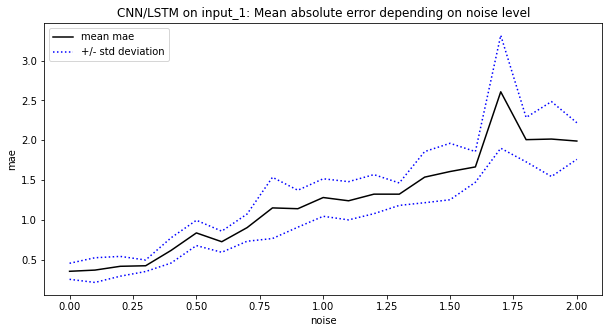

In [69]:
# Saved grid search result in hard-coded manner:
CNNLSTM_input1_mean_grid_accuracy = np.array([0.7852, 0.5546, 0.5086, 0.523 , 0.5005, 0.4811, 0.501 , 0.5001,
       0.4876, 0.5245, 0.4893, 0.5129, 0.5056, 0.5037, 0.5051, 0.5147,
       0.5177, 0.5235, 0.5118, 0.5362, 0.5219])
CNNLSTM_input1_mean_grid_mae = np.array([0.35316, 0.36831, 0.41602, 0.42286, 0.61517, 0.83541, 0.72472,
       0.90207, 1.14974, 1.13956, 1.28012, 1.23926, 1.32251, 1.32229,
       1.53625, 1.60669, 1.66469, 2.60873, 2.0072 , 2.01474, 1.98976])
CNNLSTM_input1_std_grid_mae = np.array([0.10073768, 0.15517639, 0.12431515, 0.072364  , 0.15860163,
       0.15903586, 0.13274339, 0.17107248, 0.38495531, 0.23208765,
       0.23567647, 0.24025105, 0.24543559, 0.14095194, 0.32129729,
       0.35471393, 0.19298967, 0.70905796, 0.27892068, 0.47076398,
       0.23008148])

# Plot mean mae (with +/- std) over noise grid
fig, axes = plt.subplots(1, 1, figsize=(10,5))
axes.plot(noise_grid, CNNLSTM_input1_mean_grid_mae, color="k", label="mean mae")
axes.plot(noise_grid, CNNLSTM_input1_mean_grid_mae + CNNLSTM_input1_std_grid_mae, color="b", linestyle="dotted", label="+/- std deviation")
axes.plot(noise_grid, CNNLSTM_input1_mean_grid_mae - CNNLSTM_input1_std_grid_mae, color="b", linestyle="dotted")
axes.set_xlabel("noise")
axes.set_ylabel("mae")
axes.set_title("CNN/LSTM on input_1: Mean absolute error depending on noise level")
axes.legend()
plt.show()

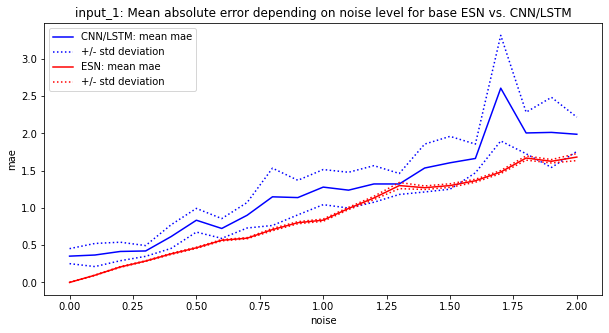

In [70]:
# Input_1: Plot mean mae (with +/- std) over noise grid for ESN compared to CNN/LSTM
fig, axes = plt.subplots(1, 1, figsize=(10,5))
axes.plot(noise_grid, CNNLSTM_input1_mean_grid_mae, color="b", label="CNN/LSTM: mean mae")
axes.plot(noise_grid, CNNLSTM_input1_mean_grid_mae + CNNLSTM_input1_std_grid_mae, color="b", linestyle="dotted", label="+/- std deviation")
axes.plot(noise_grid, CNNLSTM_input1_mean_grid_mae - CNNLSTM_input1_std_grid_mae, color="b", linestyle="dotted")
axes.plot(noise_grid, ESN_input1_mean_grid_mae, color="r", label="ESN: mean mae")
axes.plot(noise_grid, ESN_input1_mean_grid_mae + ESN_input1_std_grid_mae, color="r", linestyle="dotted", label="+/- std deviation")
axes.plot(noise_grid, ESN_input1_mean_grid_mae - ESN_input1_std_grid_mae, color="r", linestyle="dotted")
axes.set_xlabel("noise")
axes.set_ylabel("mae")
axes.set_title("input_1: Mean absolute error depending on noise level for base ESN vs. CNN/LSTM")
axes.legend()
plt.show()

### input_1: Discussion or multirun results for ESN vs. CNN/LSTM

* ESN requires shorter input length (10d vs. 16d)
* used base ESN comes with 100 trainable weights (n_res = 100), opposed to 5.500 parameters in CNN/LSTM
* CNN/LSTM needs 20 times more computing time than base ESN for training
* mean mae is not only lower for ESN, but also in a quite narrow range (stability / reproducibility)

However: The observed dis-advantage of CNN/LSTM could be due to un-sufficient training. Need to repeat multirun with more epochs in training CNN/LSTM network!!!

### Multirun CNN/LSTM on modified input_4 with varying noise level

Differences to multirun ESN:

* CNN/LSTM works with slightly longer input length: 16 days
* And CNN/LSTM works best with scaled absolute values, whereas ESN's performance doesn't depend on scaling.

In [157]:
# Set number of runs per noise level
n_runs = 10

# Set noise levels
noise_grid = np.linspace(0,2,21)
print("noise_grid: ", noise_grid)

# Get verbose function outputs:
verbose = False

# Set input and target parameters:
input_length = 16
target_length = 1
time_lag = 0
train_val_split = 0.8
val_samples_from = 'start_end'

# Work with unscaled absolute values:
abs_to_rel_YN = False
binary_YN = False
scaled_YN = True
abs_values_YN = True

# Initialize arrays for storing accuracy and mae for each run for each parameter selection.
grid_accuracy = np.zeros((len(noise_grid), n_runs))
grid_mae = np.zeros((len(noise_grid), n_runs))

### Preparing CNN/LSTM model setup

# number of input features
num_channels = 1

# input dimensions
input_shape = (input_length, num_channels)    
num_inputs = input_length * num_channels
num_outputs = 1 

# further parameters: weight/bias initialization
weight_init = tfi.glorot_uniform() # tfi.RandomUniform(minval=-0.05, maxval=0.05, seed=None)  tfi.RandomNormal()
bias_init = tfi.Zeros()

# further parameters: regularization
kernel_reg_CNN=tfr.l1_l2(l1=0, l2=0) # (l1=1e-5, l2=1e-4)
bias_reg_CNN=tfr.l2(0) # l2(1e-4) 
kernel_reg_LSTM=tfr.l1_l2(l1=0, l2=0) # (l1=1e-5, l2=1e-4)
bias_reg_LSTM=tfr.l2(0) # l2(1e-4) 
kernel_reg_Dense=tfr.l1_l2(l1=0, l2=0) # (l1=1e-5, l2=1e-4)
bias_reg_Dense=tfr.l2(0) # l2(1e-4) 

# batch size and epochs
batch_size = 20  
epochs = 16

# Note runtime: Start
start = time.time()

# Loop over noise levels in noise_grid:
for i in range(len(noise_grid)):
    
    # Get current n_res
    noise = noise_grid[i]
    
    # Create input according to current noise level: 

    # Specify number of steps per regime.
    n_ = 1000

    # Specify input for sin function with linspace(start, stop, numsteps)
    t = np.linspace(0, 20*np.pi, n_) 
    
    # Set the two amplitudes a1 and a2, and the two frequencies f1, f2
    a1 = 1
    a2 = 0.5
    f1 = 1
    f2 = 2

    # Set noise standard deviation parameter n1
    n1 = noise

    # Add noise with np.random.normal(mean, std, numsteps).
    input = np.concatenate((a1 * np.sin(f1 * t[:int(n_ / 2)]), a2 * np.sin(f2 * t[int(n_ / 2):]))) + np.random.normal(0, n1, n_)

    # Loop over number of runs:
    for run in range(n_runs):

        # print status:
        print("noise level : ", i+1, " of ", len(noise_grid), ", run: ", run+1, " of ", n_runs)

        # Create inputs and targets from absolute data
        train_input, val_input, train_target, val_target, train_min, train_max = split_data(input, 
                                                                                            input_length = input_length, 
                                                                                            target_length = target_length, 
                                                                                            time_lag=time_lag,
                                                                                            train_val_split=train_val_split, 
                                                                                            val_samples_from=val_samples_from,
                                                                                            abs_to_rel_YN=abs_to_rel_YN,
                                                                                            binary_YN=binary_YN, 
                                                                                            scaled_YN=scaled_YN,
                                                                                            verbose=verbose)

        
        
        # define model: hybrid CNN-LSTM         
        model = Sequential()
        model.add(Conv1D(filters=10, kernel_size=7, input_shape=input_shape, strides=1, kernel_initializer=weight_init, bias_initializer = bias_init, kernel_regularizer=kernel_reg_CNN, bias_regularizer=bias_reg_CNN))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.3))
        model.add(Conv1D(filters=20, kernel_size=4, strides=1, kernel_initializer=weight_init, bias_initializer = bias_init, kernel_regularizer=kernel_reg_CNN, bias_regularizer=bias_reg_CNN))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.3))
        model.add(LSTM(20, bias_initializer="zeros", return_sequences=True, kernel_regularizer=kernel_reg_LSTM, bias_regularizer=bias_reg_LSTM))
        #model.add(Dropout(0.5))
        model.add(LSTM(10, kernel_regularizer=kernel_reg_LSTM, bias_regularizer=bias_reg_LSTM))
        #model.add(Dropout(0.5))
        model.add(Dense(units=num_outputs, name = "output", activation = 'linear', kernel_initializer=weight_init, bias_initializer = bias_init, kernel_regularizer=kernel_reg_Dense, bias_regularizer=bias_reg_Dense))

        # compile model (with constant lr)
        model.compile(optimizer=Adam(learning_rate=0.0001),loss='mean_squared_error',metrics=['mae'])

        # train model
        history = model.fit(train_input, train_target, epochs=epochs, batch_size=batch_size, shuffle=True, verbose=verbose, validation_data=(val_input, val_target))


        
        
        

       # Get prediction on validation data and evaluation metrics
        val_target, val_pred, accuracy, mae = predCNNLSTM(val_input, val_target,
                                                  model,
                                                  target_length=target_length,
                                                  abs_values_YN=abs_values_YN,
                                                  scaled_YN=scaled_YN, 
                                                  train_min=train_min, 
                                                  train_max=train_max, 
                                                  abs_base=1.0,
                                                  verbose=verbose)

        # Store accuracy and mae for current run for current parameter selection:
        grid_accuracy[i,run] = accuracy
        grid_mae[i,run] = mae

# Get runtime:
duration = time.time() - start
print("Total runtime: ", duration)

noise_grid:  [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2. ]
noise level :  1  of  21 , run:  1  of  10
noise level :  1  of  21 , run:  2  of  10
noise level :  1  of  21 , run:  3  of  10
noise level :  1  of  21 , run:  4  of  10
noise level :  1  of  21 , run:  5  of  10
noise level :  1  of  21 , run:  6  of  10
noise level :  1  of  21 , run:  7  of  10
noise level :  1  of  21 , run:  8  of  10
noise level :  1  of  21 , run:  9  of  10
noise level :  1  of  21 , run:  10  of  10
noise level :  2  of  21 , run:  1  of  10
noise level :  2  of  21 , run:  2  of  10
noise level :  2  of  21 , run:  3  of  10
noise level :  2  of  21 , run:  4  of  10
noise level :  2  of  21 , run:  5  of  10
noise level :  2  of  21 , run:  6  of  10
noise level :  2  of  21 , run:  7  of  10
noise level :  2  of  21 , run:  8  of  10
noise level :  2  of  21 , run:  9  of  10
noise level :  2  of  21 , run:  10  of  10
noise level :  3  of  21 , run:  1  of

noise level :  19  of  21 , run:  7  of  10
noise level :  19  of  21 , run:  8  of  10
noise level :  19  of  21 , run:  9  of  10
noise level :  19  of  21 , run:  10  of  10
noise level :  20  of  21 , run:  1  of  10
noise level :  20  of  21 , run:  2  of  10
noise level :  20  of  21 , run:  3  of  10
noise level :  20  of  21 , run:  4  of  10
noise level :  20  of  21 , run:  5  of  10
noise level :  20  of  21 , run:  6  of  10
noise level :  20  of  21 , run:  7  of  10
noise level :  20  of  21 , run:  8  of  10
noise level :  20  of  21 , run:  9  of  10
noise level :  20  of  21 , run:  10  of  10
noise level :  21  of  21 , run:  1  of  10
noise level :  21  of  21 , run:  2  of  10
noise level :  21  of  21 , run:  3  of  10
noise level :  21  of  21 , run:  4  of  10
noise level :  21  of  21 , run:  5  of  10
noise level :  21  of  21 , run:  6  of  10
noise level :  21  of  21 , run:  7  of  10
noise level :  21  of  21 , run:  8  of  10
noise level :  21  of  21 , ru

In [158]:
# Get mean accuracy and mean plus standard deviation of mae for grid over all runs:
mean_grid_accuracy = np.mean(grid_accuracy, axis=-1)
mean_grid_mae = np.mean(grid_mae, axis=-1)
std_grid_mae = np.std(grid_mae, axis=-1)

In [162]:
std_grid_mae

array([0.03200216, 0.0145353 , 0.01560426, 0.0097472 , 0.01361714,
       0.01653748, 0.02371685, 0.01784534, 0.02344359, 0.03441038,
       0.01609989, 0.04457242, 0.01754752, 0.02444719, 0.03499392,
       0.03406015, 0.06776623, 0.03036336, 0.04243541, 0.07307164,
       0.05072027])

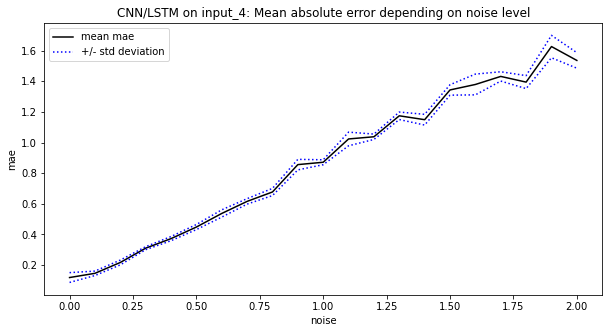

In [163]:
# Saved grid search result in hard-coded manner:
CNNLSTM_input4_mean_grid_accuracy = np.array([0.8902, 0.5547, 0.5205, 0.5138, 0.5288, 0.5149, 0.5237, 0.5743,
       0.542 , 0.544 , 0.5493, 0.5466, 0.5448, 0.5532, 0.562 , 0.5467,
       0.5504, 0.5333, 0.5564, 0.5319, 0.5527])
CNNLSTM_input4_mean_grid_mae = np.array([0.1191 , 0.14661, 0.21739, 0.3107 , 0.37306, 0.44866, 0.53731,
       0.61607, 0.6775 , 0.85604, 0.87145, 1.02346, 1.03778, 1.17461,
       1.14923, 1.34332, 1.37903, 1.43162, 1.39443, 1.6265 , 1.53598])
CNNLSTM_input4_std_grid_mae = np.array([0.03200216, 0.0145353 , 0.01560426, 0.0097472 , 0.01361714,
       0.01653748, 0.02371685, 0.01784534, 0.02344359, 0.03441038,
       0.01609989, 0.04457242, 0.01754752, 0.02444719, 0.03499392,
       0.03406015, 0.06776623, 0.03036336, 0.04243541, 0.07307164,
       0.05072027])

# Plot mean mae (with +/- std) over noise grid
fig, axes = plt.subplots(1, 1, figsize=(10,5))
axes.plot(noise_grid, CNNLSTM_input4_mean_grid_mae, color="k", label="mean mae")
axes.plot(noise_grid, CNNLSTM_input4_mean_grid_mae + CNNLSTM_input4_std_grid_mae, color="b", linestyle="dotted", label="+/- std deviation")
axes.plot(noise_grid, CNNLSTM_input4_mean_grid_mae - CNNLSTM_input4_std_grid_mae, color="b", linestyle="dotted")
axes.set_xlabel("noise")
axes.set_ylabel("mae")
axes.set_title("CNN/LSTM on input_4: Mean absolute error depending on noise level")
axes.legend()
plt.show()

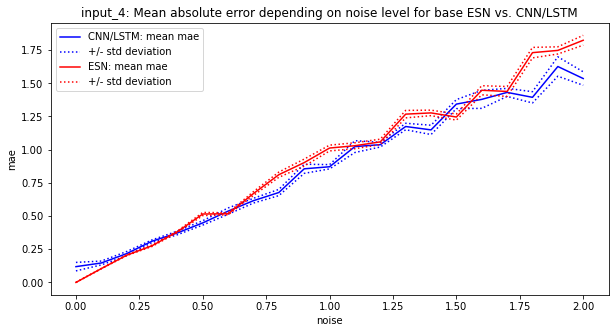

In [164]:
# Input_4: Plot mean mae (with +/- std) over noise grid for ESN compared to CNN/LSTM
fig, axes = plt.subplots(1, 1, figsize=(10,5))
axes.plot(noise_grid, CNNLSTM_input4_mean_grid_mae, color="b", label="CNN/LSTM: mean mae")
axes.plot(noise_grid, CNNLSTM_input4_mean_grid_mae + CNNLSTM_input4_std_grid_mae, color="b", linestyle="dotted", label="+/- std deviation")
axes.plot(noise_grid, CNNLSTM_input4_mean_grid_mae - CNNLSTM_input4_std_grid_mae, color="b", linestyle="dotted")
axes.plot(noise_grid, ESN_input4_mean_grid_mae, color="r", label="ESN: mean mae")
axes.plot(noise_grid, ESN_input4_mean_grid_mae + ESN_input4_std_grid_mae, color="r", linestyle="dotted", label="+/- std deviation")
axes.plot(noise_grid, ESN_input4_mean_grid_mae - ESN_input4_std_grid_mae, color="r", linestyle="dotted")
axes.set_xlabel("noise")
axes.set_ylabel("mae")
axes.set_title("input_4: Mean absolute error depending on noise level for base ESN vs. CNN/LSTM")
axes.legend()
plt.show()

### input_4: Discussion or multirun results for ESN vs. CNN/LSTM

* ESN requires shorter input length (10d vs. 16d)
* used base ESN comes with 100 trainable weights (n_res = 100), opposed to 5.500 parameters in CNN/LSTM
* CNN/LSTM needs 20 times more computing time than base ESN for training
* CNN/LSTM outperforms ESN slightly in terms of mean-absolute-error (mae).
* But find mae for ESN spreading less.

### Next steps:

* repeat multirun analysis for CNNLSTM on input_1 with more training epochs
* add multirun analysis for CNNLSTM on input_2 and _3
* outlook: implement free-float prediction in addition to one-step with "teacher-forcing"